In [1]:
import numpy as np
import matplotlib.pyplot as plt

import pickle
import os
import pandas as pd
import json
from itertools import compress
import math

from scipy import signal 

import glob

from DataManager import ParticipantData, MeasurementData
from Helpers import read_normalized_json_to_df, save_to_disk, load_from_disk, create_rolling_windows, \
   intersection, reject_outliers, anglebetween, eye_outlier_removal_sigma, eye_outlier_removal_zero_values

In [2]:
reference_data_all_failed_save_path = "./post_recorded_reference_data/reference_dict_all.pickle"
REFERENCE_DATA_ALL_EVENTS_FAILED = load_from_disk(reference_data_all_failed_save_path)

correlation_dict_path = "./post_recorded_reference_data/corr_dict.pickle"
CORRELATION_DICT = load_from_disk(correlation_dict_path)

# Load data

In [3]:
# global location variable 
GLOBAL_AREA = 'Westbrueck'  # orig Westbrueck
GLOBAL_SEGMENT = 0 # orig 0
GLOBAL_SINGLE_PARTICIPANT = '0bc17d704fec4a9eb892d905fc2e5da9'

In [4]:
verbose = False

eyes_paths  = ["./data/EyeTracking/"]
input_paths = ["./data/Input/"]
calib_paths = ["./data/ParticipantCalibrationData/"]
scene_paths = ["./data/SceneData/"]

measurement1 = MeasurementData(eyes_paths,input_paths,calib_paths,scene_paths,verbose)


ParticipantData: Initialising participant 0d0d7bd79b1a48d4ad5e757cdbfc15c9.
ParticipantData: Loaded data (bootstrapped) for participant 0d0d7bd79b1a48d4ad5e757cdbfc15c9.
ParticipantData: Initialising participant 0bc17d704fec4a9eb892d905fc2e5da9.
ParticipantData: Loaded data (bootstrapped) for participant 0bc17d704fec4a9eb892d905fc2e5da9.


In [5]:
measurement1.apply_reference_data(REFERENCE_DATA_ALL_EVENTS_FAILED)

MeasurementData: Applying reference data to all participants...
MeasurementData: Done applying reference data to all participants.


In [6]:
print("Available participants: \n" + str(measurement1.get_participant_list()))
print()

Available participants: 
['0d0d7bd79b1a48d4ad5e757cdbfc15c9', '0bc17d704fec4a9eb892d905fc2e5da9']



# Extract participant data

In [7]:
### Reference data applied 

# Extract data of one participant, of one area, of one segment 
participant_exclusion_list = [p for p in measurement1.get_participant_list() if p != GLOBAL_SINGLE_PARTICIPANT]
one_participant_single_segment = measurement1.get_data(use_vanilla=False, filter_data=True, \
                 filter_by_corr_coeff_dict=CORRELATION_DICT, corr_coeff_threshold=0.95, \
                 exclude_participants=participant_exclusion_list)
one_participant_single_segment = one_participant_single_segment[GLOBAL_SINGLE_PARTICIPANT][GLOBAL_AREA][GLOBAL_SEGMENT] 

# Average data over multiple sessions per segment
average_over_all_participants = measurement1.get_data(use_vanilla = False, filter_data=True, filter_by_corr_coeff_dict=CORRELATION_DICT, corr_coeff_threshold=0.95, exclude_participants=[])
average_over_all_participants = measurement1.average_data(average_over_all_participants)
average_over_all_participants_single_segment = average_over_all_participants[GLOBAL_AREA][GLOBAL_SEGMENT] 


/Users/stefan/opt/anaconda3/envs/Body2Eye/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  warnings.warn(


In [8]:
### No reference data applied 

# Extract data of one participant, of one area, of one segment without ref data applied 
participant_exclusion_list = [p for p in measurement1.get_participant_list() if p != GLOBAL_SINGLE_PARTICIPANT]
one_participant_single_segment_no_ref_applied = measurement1.get_data(use_vanilla=True, filter_data=True, \
                 filter_by_corr_coeff_dict=CORRELATION_DICT, corr_coeff_threshold=0.95, \
                 exclude_participants=participant_exclusion_list)
one_participant_single_segment_no_ref_applied = \
    one_participant_single_segment_no_ref_applied[GLOBAL_SINGLE_PARTICIPANT][GLOBAL_AREA][GLOBAL_SEGMENT]

# Extract reference data for one area, one segment 
ref_data_one_participant_single_segment = REFERENCE_DATA_ALL_EVENTS_FAILED[GLOBAL_AREA][GLOBAL_SEGMENT]  


# Investigating outliers in vanilla data

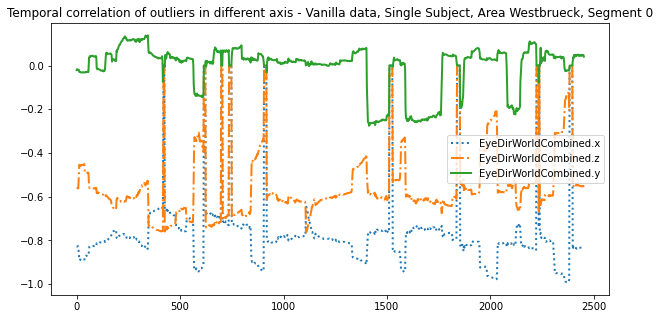

In [9]:
plt.figure(figsize=(10,5))
plt.plot(one_participant_single_segment_no_ref_applied['EyeDirWorldCombined.x'], linewidth=2, linestyle=':')
plt.plot(one_participant_single_segment_no_ref_applied['EyeDirWorldCombined.z'], linewidth=2, linestyle='-.')
plt.plot(one_participant_single_segment_no_ref_applied['EyeDirWorldCombined.y'], linewidth=2)

plt.title("Temporal correlation of outliers in different axis - Vanilla data, Single Subject, Area " + GLOBAL_AREA + ", Segment " + str(GLOBAL_SEGMENT))
plt.legend(['EyeDirWorldCombined.x', 'EyeDirWorldCombined.z', 'EyeDirWorldCombined.y'])
plt.show()

Outlier detection Method: Standard Deviation
Overwritten data: 3.913575214023645%


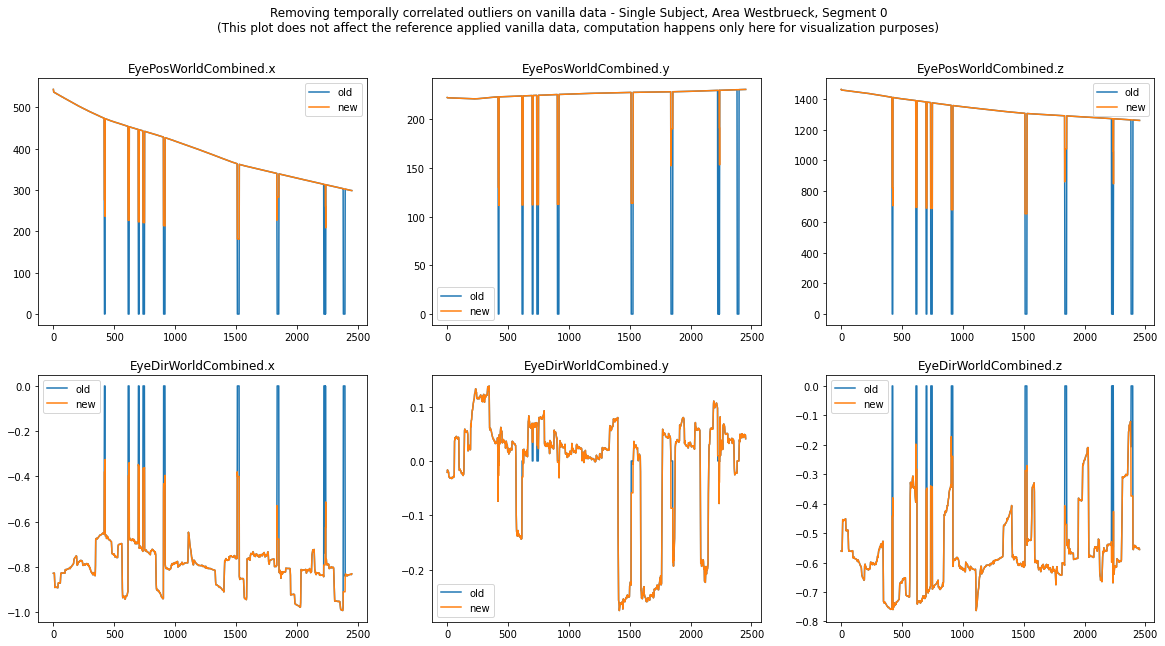

In [10]:
old_pos_x = one_participant_single_segment_no_ref_applied['EyePosWorldCombined.x']
old_pos_y = one_participant_single_segment_no_ref_applied['EyePosWorldCombined.y']
old_pos_z = one_participant_single_segment_no_ref_applied['EyePosWorldCombined.z']

old_dir_x = one_participant_single_segment_no_ref_applied['EyeDirWorldCombined.x']
old_dir_y = one_participant_single_segment_no_ref_applied['EyeDirWorldCombined.y']
old_dir_z = one_participant_single_segment_no_ref_applied['EyeDirWorldCombined.z']

'''
pos_x, pos_y, pos_z, dir_x, dir_y, dir_z, info, outliers = \
    eye_outlier_removal_zero_values(old_pos_x, old_pos_y, old_pos_z, old_dir_x, old_dir_y, old_dir_z, padding=8)
print("Outlier detection Method: Zero Values with padding")
print("Overwritten data: " + str(info["Amount of data (incl. padding) (%)"].sum()) + "%")
'''

pos_x, pos_y, pos_z, dir_x, dir_y, dir_z, info, outliers = \
    eye_outlier_removal_sigma(old_pos_x, old_pos_y, old_pos_z, old_dir_x, old_dir_y, old_dir_z, m=2)
print("Outlier detection Method: Standard Deviation")
print("Overwritten data: " + str(info["Data Prop (%)"].sum()) + "%")


plt.figure(figsize=(20,10))

plt.subplot(2,3,1)
plt.plot(old_pos_x)
plt.plot(pos_x)
plt.legend(["old","new"])
plt.title('EyePosWorldCombined.x')

plt.subplot(2,3,2)
plt.plot(old_pos_y)
plt.plot(pos_y)
plt.legend(["old","new"])
plt.title('EyePosWorldCombined.y')

plt.subplot(2,3,3)
plt.plot(old_pos_z)
plt.plot(pos_z)
plt.legend(["old","new"])
plt.title('EyePosWorldCombined.z')

plt.subplot(2,3,4)
plt.plot(old_dir_x)
plt.plot(dir_x)
plt.legend(["old","new"])
plt.title('EyeDirWorldCombined.x')

plt.subplot(2,3,5)
plt.plot(old_dir_y)
plt.plot(dir_y)
plt.legend(["old","new"])
plt.title('EyeDirWorldCombined.y')

plt.subplot(2,3,6)
plt.plot(old_dir_z)
plt.plot(dir_z)
plt.legend(["old","new"])
plt.title('EyeDirWorldCombined.z')

plt.suptitle("Removing temporally correlated outliers on vanilla data - Single Subject, Area " + GLOBAL_AREA + ", Segment " + str(GLOBAL_SEGMENT) \
            + "\n(This plot does not affect the reference applied vanilla data, computation happens only here for visualization purposes)")

plt.show()

# Comparing vanilla & reference data applied & reference data

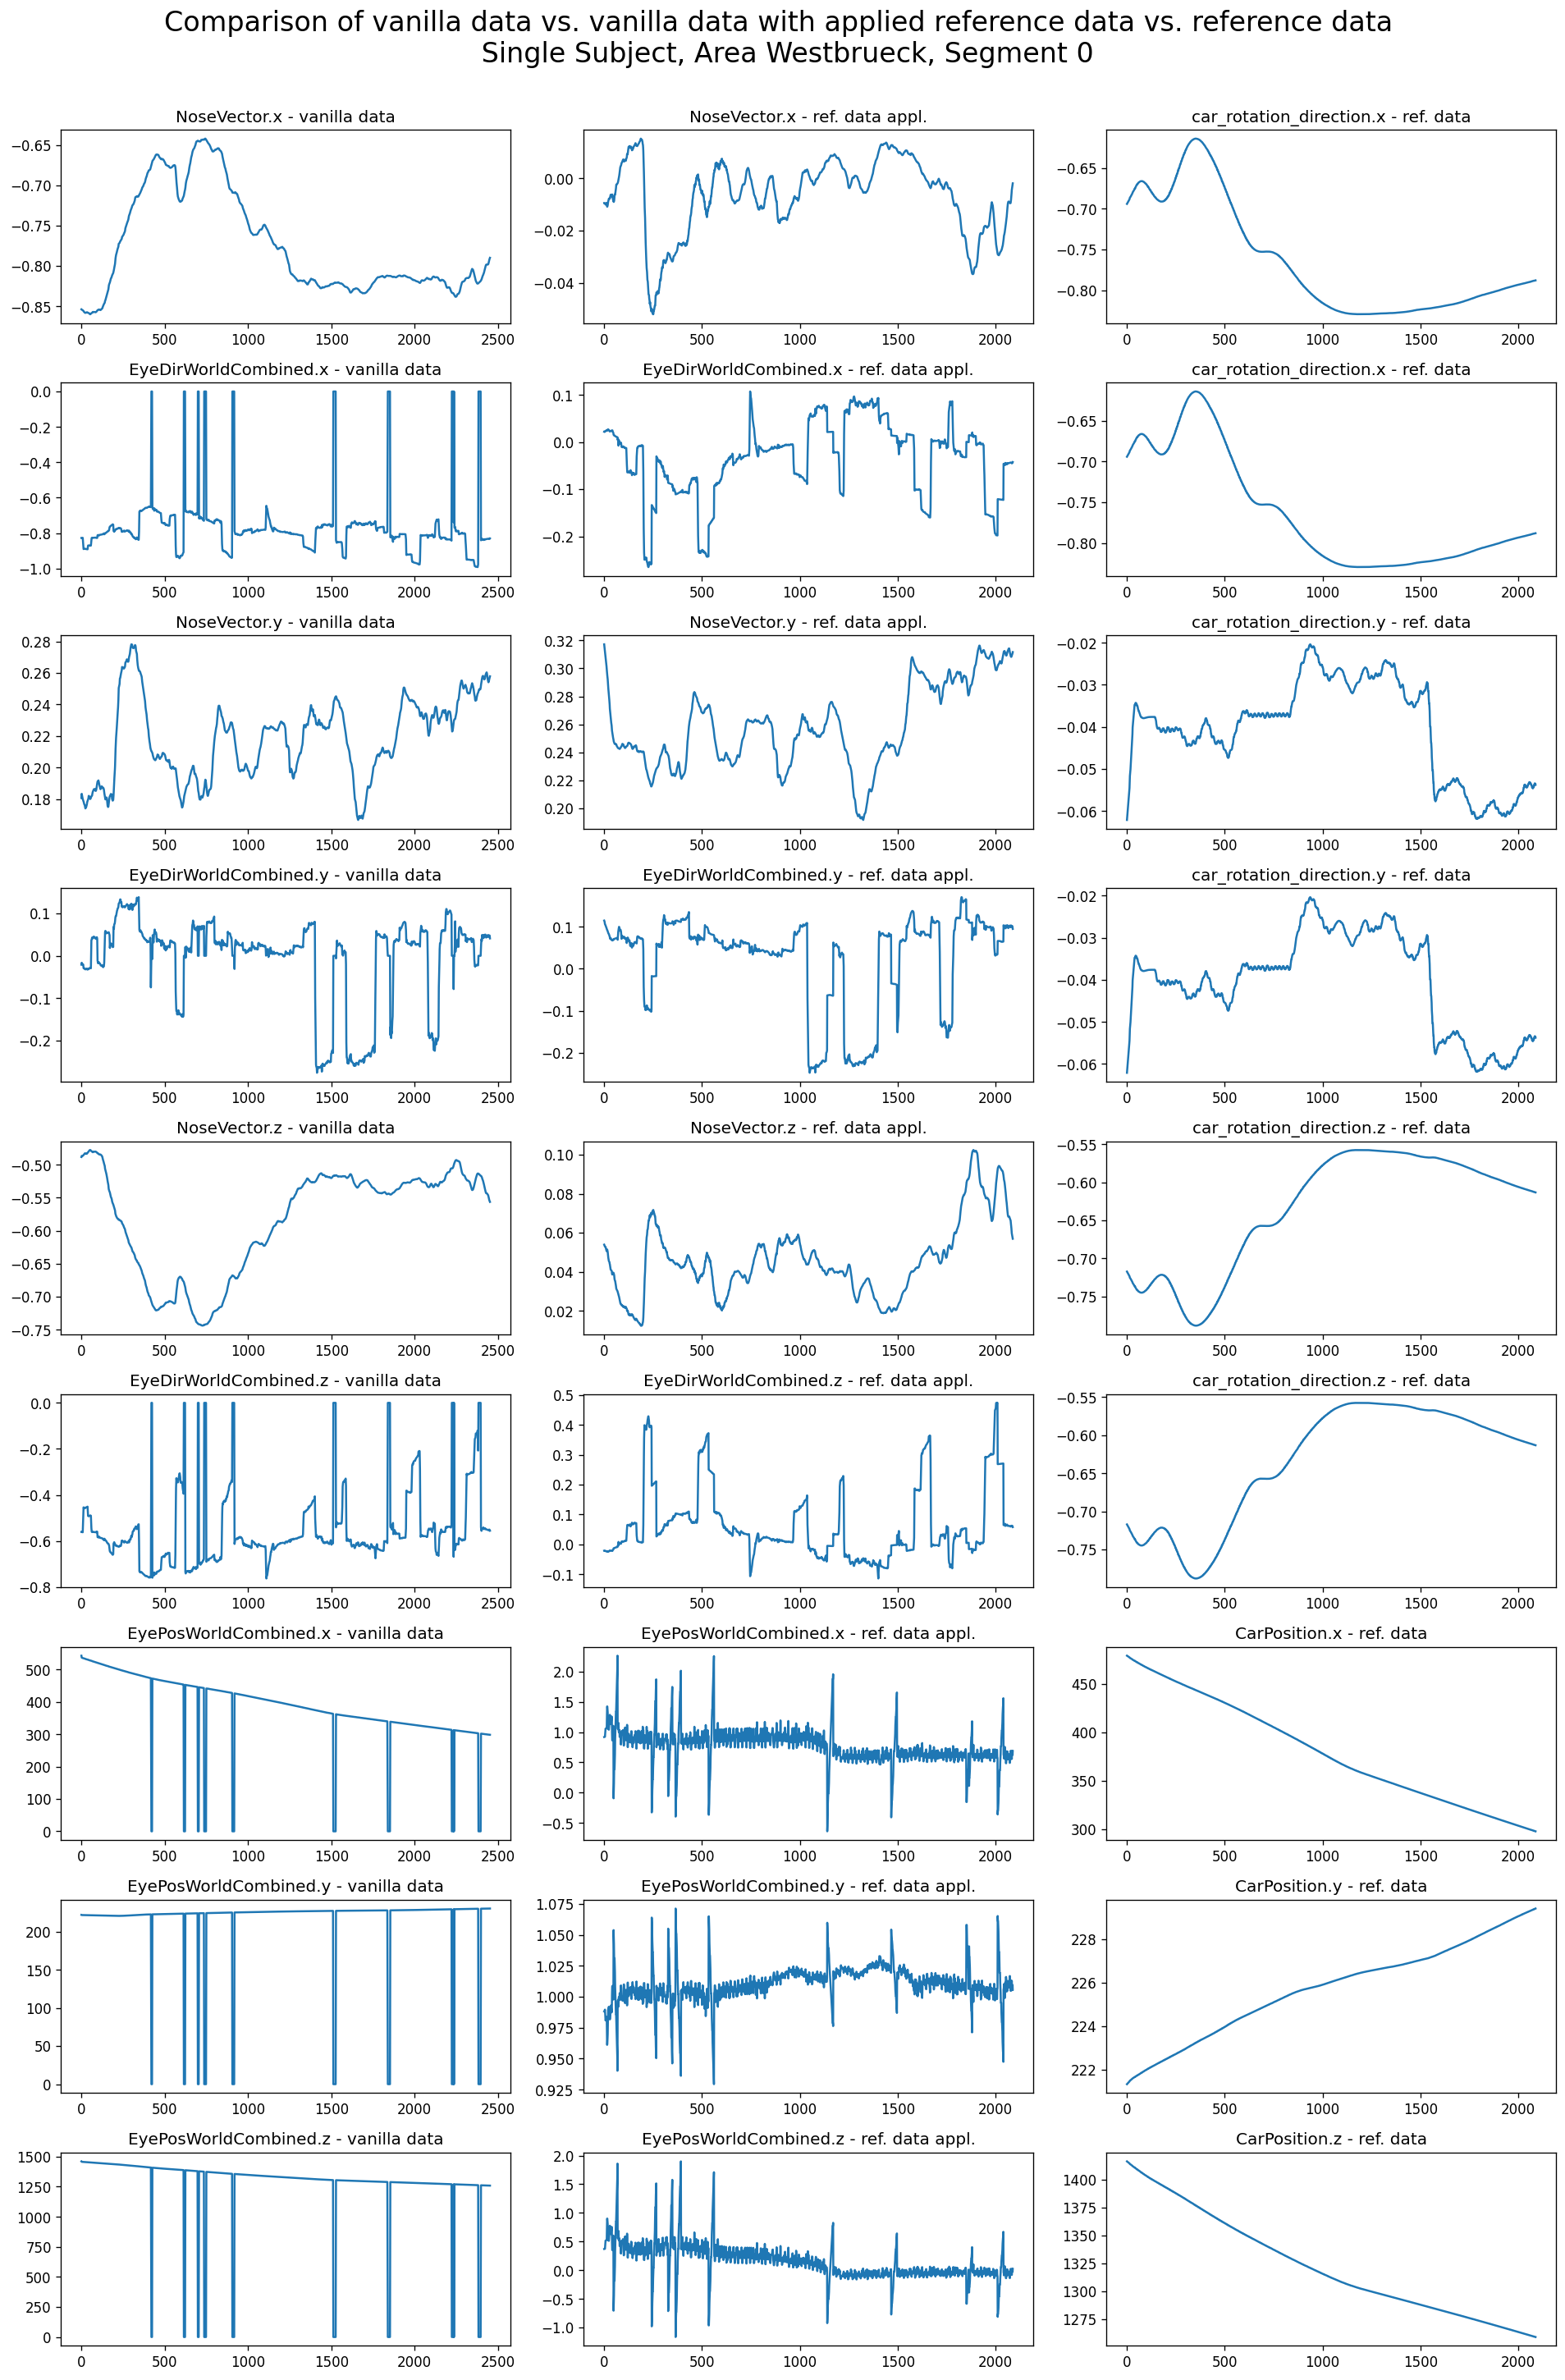

In [11]:
# Names of data columns to plot 
names_x = ["NoseVector.x","NoseVector.x",'car_rotation_direction.x',"EyeDirWorldCombined.x","EyeDirWorldCombined.x",'car_rotation_direction.x', \
           "NoseVector.y","NoseVector.y",'car_rotation_direction.y',"EyeDirWorldCombined.y","EyeDirWorldCombined.y",'car_rotation_direction.y', \
           "NoseVector.z","NoseVector.z",'car_rotation_direction.z',"EyeDirWorldCombined.z","EyeDirWorldCombined.z",'car_rotation_direction.z', \
           'EyePosWorldCombined.x','EyePosWorldCombined.x','CarPosition.x', \
           'EyePosWorldCombined.y','EyePosWorldCombined.y','CarPosition.y', \
           'EyePosWorldCombined.z','EyePosWorldCombined.z','CarPosition.z']

# plot comparison 
fig, ax = plt.subplots(nrows=9, ncols=3, figsize=(16,24), dpi=120)

for idx, row in enumerate(ax.reshape(-1)):
    
    # First column: Vanilla data 
    if idx % 3 == 0:
        
        x = one_participant_single_segment_no_ref_applied[names_x[idx]]
        row.plot(x)
        row.set_title(names_x[idx] + " - vanilla data")
        
    # Second column: Vanilla + reference data applied 
    elif idx % 3 == 1:
        
        x = one_participant_single_segment[names_x[idx]]
        row.plot(x)
        row.set_title(names_x[idx] + " - ref. data appl.")
    
    # Third column: Reference data
    elif idx % 3 == 2:
        
        x = ref_data_one_participant_single_segment[names_x[idx]] 
        row.plot(x)
        row.set_title(names_x[idx] + " - ref. data")


fig.suptitle("Comparison of vanilla data vs. vanilla data with applied reference data vs. reference data \n Single Subject, Area " + GLOBAL_AREA + ", Segment " + str(GLOBAL_SEGMENT),fontsize=20, y=1.005)
    
fig.tight_layout() 
plt.show()

# Checking for data similarity (Nose to Eye)

New: 
* X:
    * Somewhat evenly distributed left and right
* Y:
    * NoseY is always positive, i.e. head slightly raised 
    * Could be VR effect due to the HMD weight 
* Z: 
    * Mostly positive 
    * Some negative spikes? 


Old: Pre-update of direction calculation
* X - Sanity:
    * always positive, i.e. subjects look towards the right
    * Makes sense since subjects sit on left car seat and look at central information aways from steering wheel
* Y - Sanity:
    * NoseY is always positive, i.e. head slightly raised, but eyes are level 
    * Could be VR effect due to the HMD weight
* Z - Sanity:
    * Always negative
    * Hypothesis: Car drives in negative z direction in the scene 
   

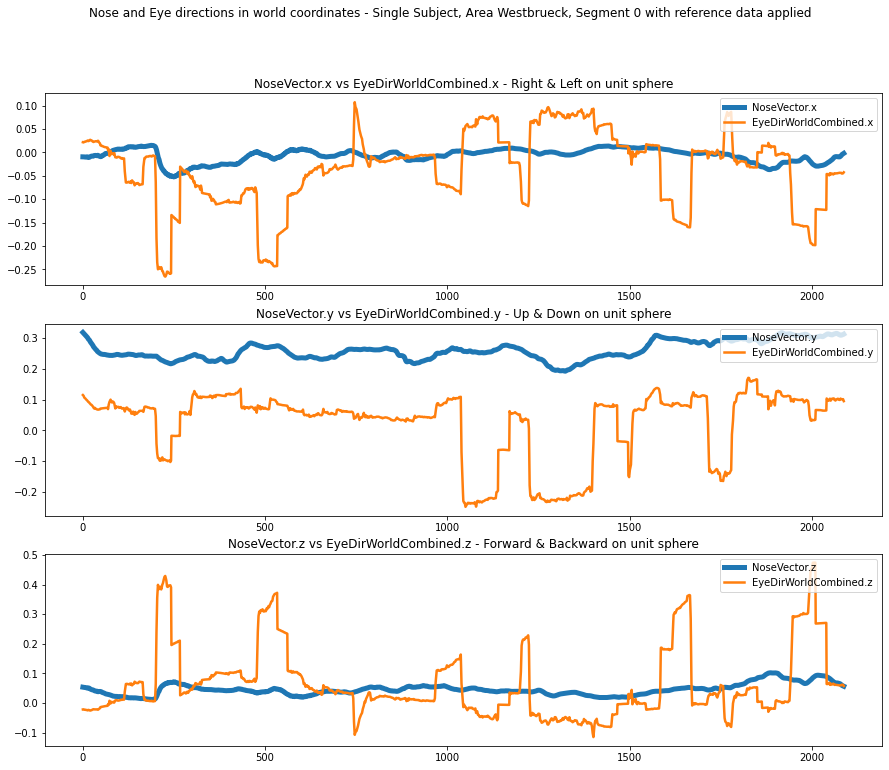

In [12]:
# X
nose_x= one_participant_single_segment['NoseVector.x'] 
eye_x = one_participant_single_segment['EyeDirWorldCombined.x'] 

# Y
nose_y = one_participant_single_segment['NoseVector.y']
eye_y = one_participant_single_segment['EyeDirWorldCombined.y']

# Z
nose_z = one_participant_single_segment['NoseVector.z']
eye_z = one_participant_single_segment['EyeDirWorldCombined.z']

# Plot 
plt.figure(figsize=(15,12))
plt.subplot(3,1,1)
plt.title('NoseVector.x vs EyeDirWorldCombined.x - Right & Left on unit sphere')

plt.plot(nose_x, linewidth=5, label='NoseVector.x')
plt.plot(eye_x, linewidth=2.5, label='EyeDirWorldCombined.x')
plt.legend(loc="upper right")

plt.subplot(3,1,2)
plt.title('NoseVector.y vs EyeDirWorldCombined.y - Up & Down on unit sphere')
plt.plot(nose_y, linewidth=5,label='NoseVector.y')
plt.plot(eye_y, linewidth=2.5, label='EyeDirWorldCombined.y')
plt.legend(loc="upper right")

plt.subplot(3,1,3)
plt.title('NoseVector.z vs EyeDirWorldCombined.z - Forward & Backward on unit sphere')
plt.plot(nose_z, linewidth=5, label='NoseVector.z')
plt.plot(eye_z, linewidth=2.5, label='EyeDirWorldCombined.z')
plt.legend(loc="upper right")

plt.suptitle("Nose and Eye directions in world coordinates - Single Subject, Area " + GLOBAL_AREA + ", Segment " + str(GLOBAL_SEGMENT) + " with reference data applied")

plt.show()

In [13]:
'''
* Unity coordinate system (z is forward)

    /\ y
    |
    |    /\ z (forward)
    |    /
    |   /  
    |  /
    | /
    |------------>   x
    /
   /|
  / | 

'''

'\n* Unity coordinate system (z is forward)\n\n    /\\ y\n    |\n    |    /\\ z (forward)\n    |    /\n    |   /  \n    |  /\n    | /\n    |------------>   x\n    /\n   /|\n  / | \n\n'

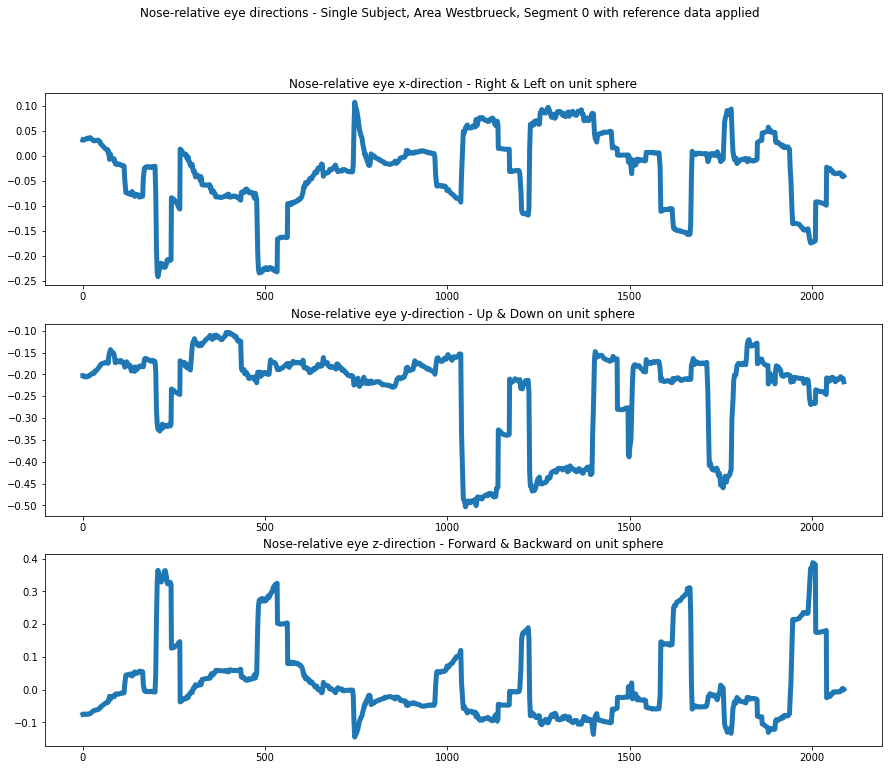

In [14]:
# Compute horizontal and vertical thetas (eye movement angles)
# Those angles are relative to the eyes looking straight ahead
# So the EyeDirWorld values need to be "normalized" using the nose vector 
# (which points in the same direction as the eyes looking straight ahead)

# Nose relative eye X 
localized_x = one_participant_single_segment['EyeDirWorldCombined.x'] - one_participant_single_segment['NoseVector.x'] 

# Nose relative eye Y
localized_y = one_participant_single_segment['EyeDirWorldCombined.y'] - one_participant_single_segment['NoseVector.y'] 

# Nose relative eye Z
localized_z = one_participant_single_segment['EyeDirWorldCombined.z'] - one_participant_single_segment['NoseVector.z'] 

# Plot 
plt.figure(figsize=(15,12))

plt.subplot(3,1,1)
plt.title('Nose-relative eye x-direction - Right & Left on unit sphere')
plt.plot(localized_x, linewidth=5)

plt.subplot(3,1,2)
plt.title('Nose-relative eye y-direction - Up & Down on unit sphere')
plt.plot(localized_y, linewidth=5)

plt.subplot(3,1,3)
plt.title('Nose-relative eye z-direction - Forward & Backward on unit sphere')
plt.plot(localized_z, linewidth=5)

plt.suptitle("Nose-relative eye directions - Single Subject, Area " + GLOBAL_AREA + ", Segment " + str(GLOBAL_SEGMENT) + " with reference data applied")

plt.show()

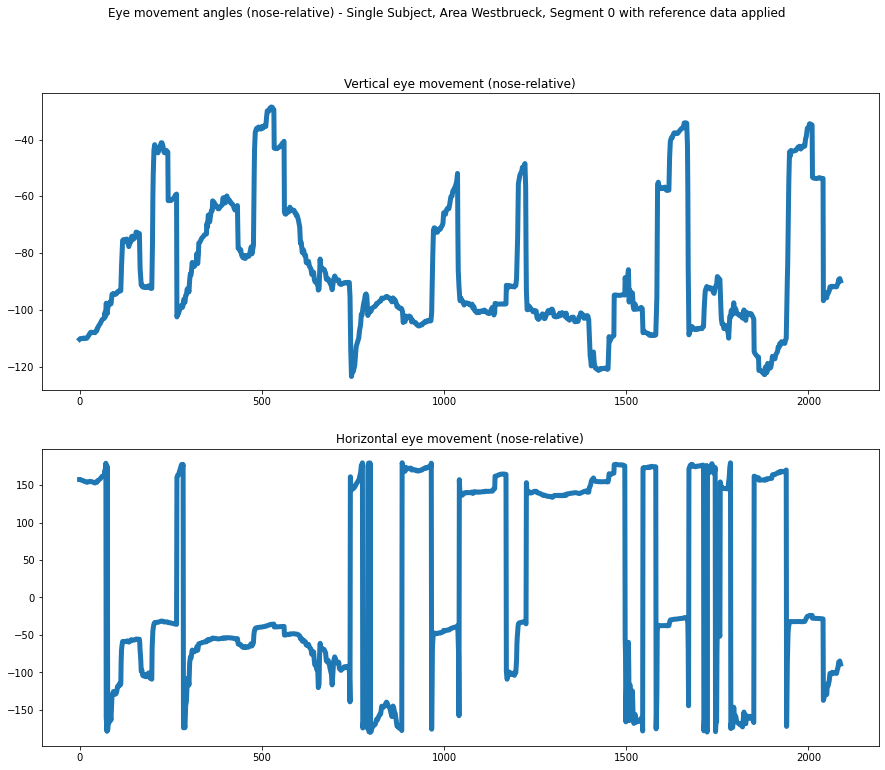

In [15]:
# Angles 
theta_vertical = np.arctan2(localized_y,localized_z) * 360 / 2 / np.pi
theta_horizontal = np.arctan2(localized_x,localized_z) * 360 / 2 / np.pi

# Plot 
plt.figure(figsize=(15,12))

plt.subplot(2,1,1)
plt.title('Vertical eye movement (nose-relative)')
plt.plot(theta_vertical, linewidth=5)

plt.subplot(2,1,2)
plt.title('Horizontal eye movement (nose-relative)')
plt.plot(theta_horizontal, linewidth=5)

plt.suptitle("Eye movement angles (nose-relative) - Single Subject, Area " + GLOBAL_AREA + ", Segment " + str(GLOBAL_SEGMENT) + " with reference data applied")

plt.show()

# Power Spectral Density Analysis
Using Welch's method

In [16]:
def plot_power_spectral_densities(segment_data,names_x,plt_title,fig_size,nrows,ncols,x_lim=-1,y_lim=-1):
    
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=fig_size, dpi=120)
    
    for idx, row in enumerate(ax.reshape(-1)):
        x = segment_data[names_x[idx]]
        f, pxx_den = signal.welch(x,fs=(1/0.01),nperseg=2048)
        row.semilogy(f, pxx_den)
        row.set_xlabel('Frequency [Hz]')
        row.set_ylabel('PSD [degree**2/Hz]')
        if x_lim > 0:
            row.set_xlim(0,x_lim)
        if y_lim > 0:
            row.set_ylim(0,y_lim)
        row.set_title(names_x[idx])

    fig.suptitle(plt_title, y=1.005)
    fig.tight_layout()
    plt.show()


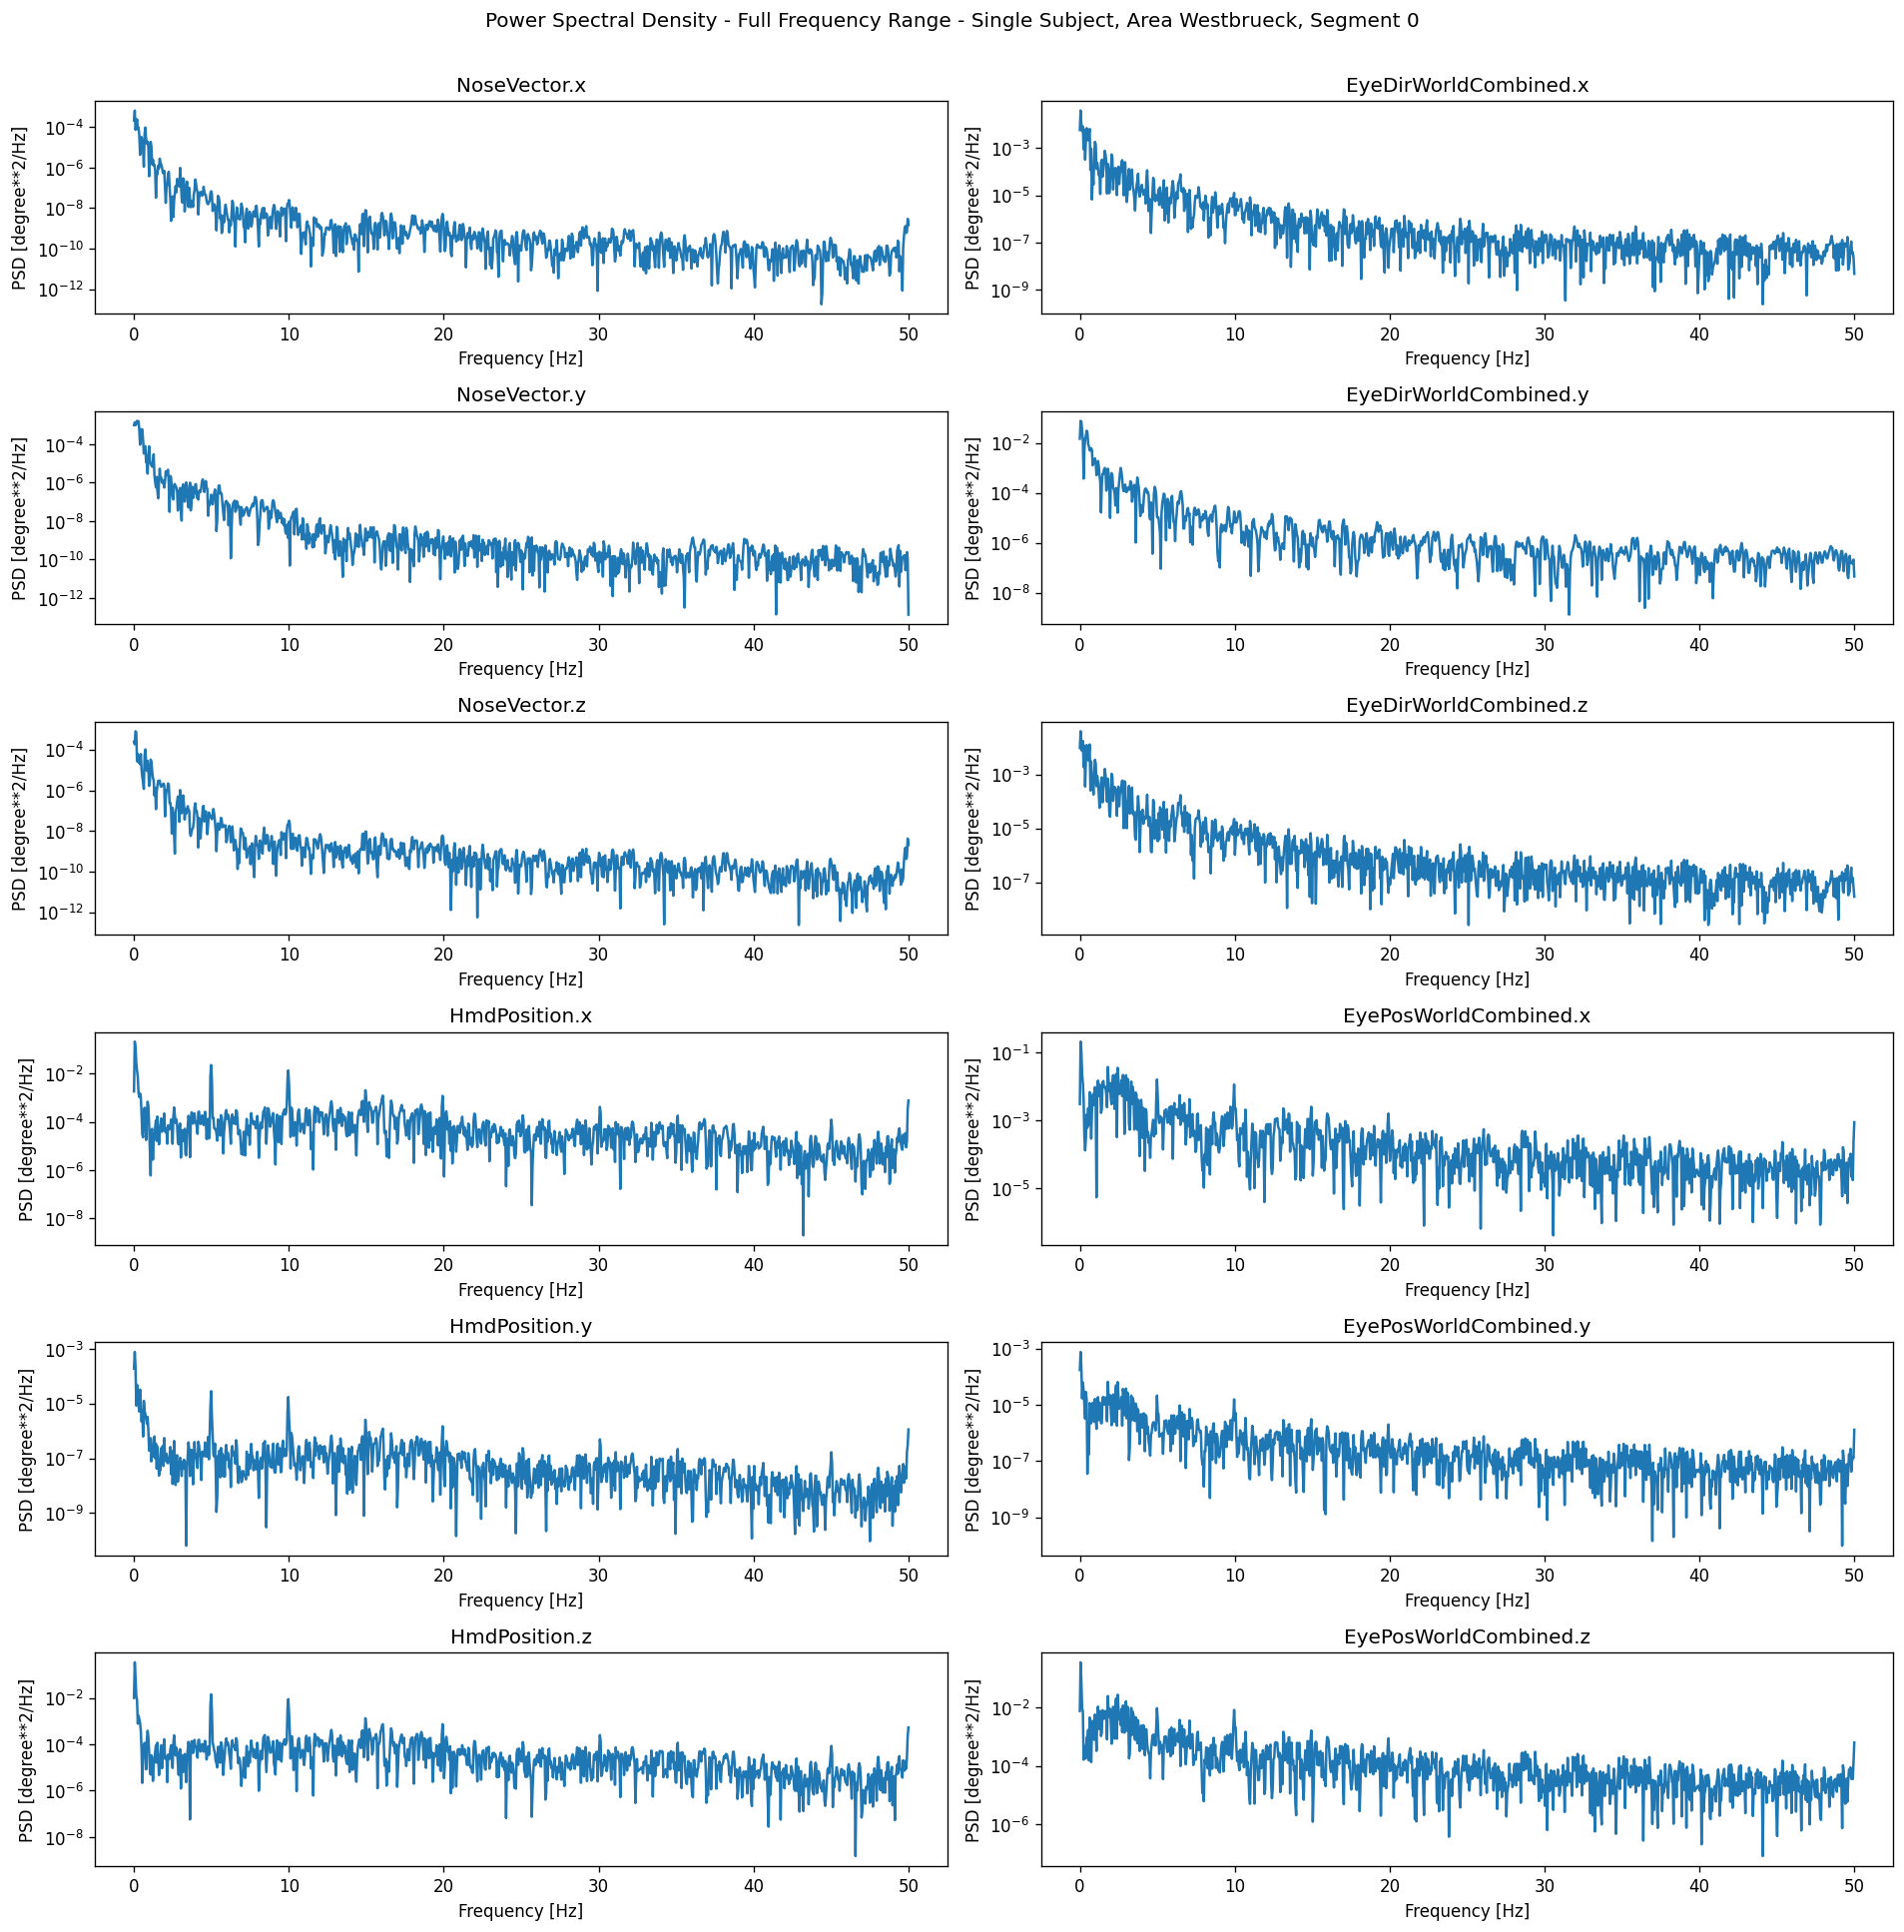

In [17]:
# Power Spectral Density - Full Frequency Range - Single Subject 

names_x = ["NoseVector.x","EyeDirWorldCombined.x","NoseVector.y","EyeDirWorldCombined.y","NoseVector.z","EyeDirWorldCombined.z", \
          "HmdPosition.x","EyePosWorldCombined.x","HmdPosition.y","EyePosWorldCombined.y","HmdPosition.z","EyePosWorldCombined.z"]
segment_data = one_participant_single_segment
plt_title = "Power Spectral Density - Full Frequency Range - Single Subject, Area " + GLOBAL_AREA + ", Segment " + str(GLOBAL_SEGMENT)
fig_size = (16,16)
nrows = 6
ncols = 2
x_lim = -1
y_lim = -1
plot_power_spectral_densities(segment_data,names_x,plt_title,fig_size,nrows,ncols,x_lim,y_lim)


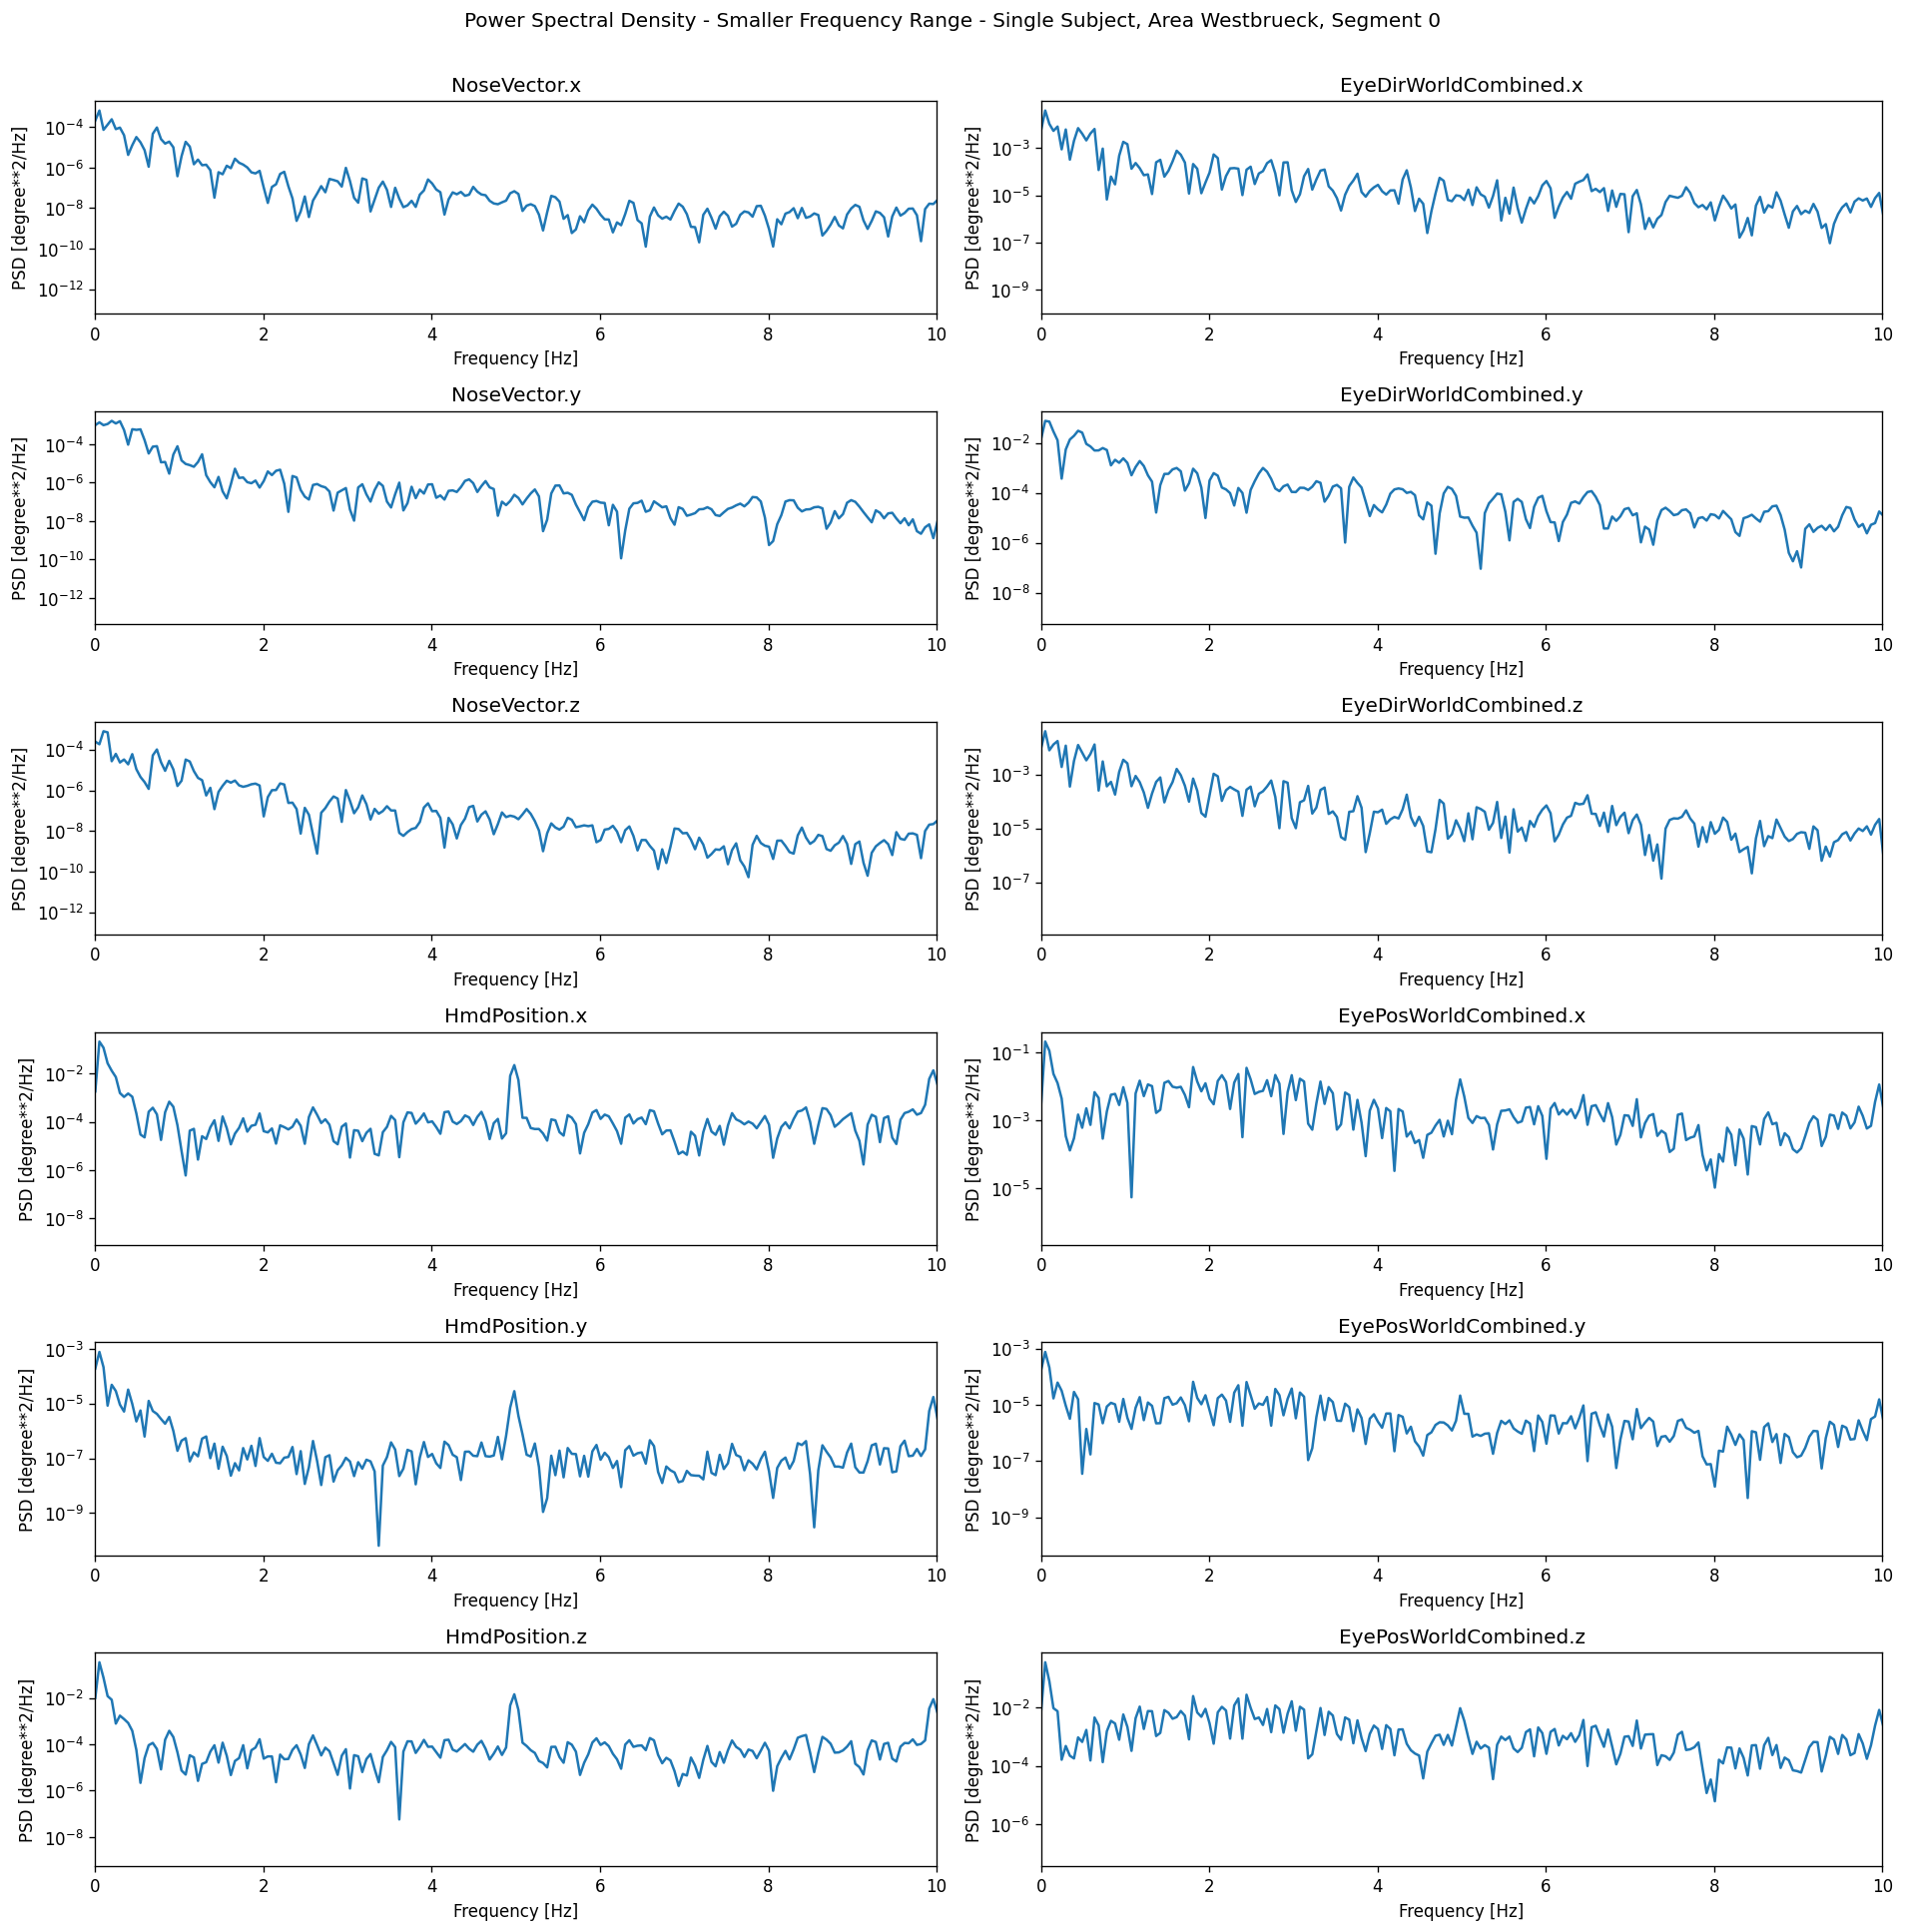

In [18]:
# Power Spectral Density - Smaller Frequency Range - Single Subject

names_x = ["NoseVector.x","EyeDirWorldCombined.x","NoseVector.y","EyeDirWorldCombined.y","NoseVector.z","EyeDirWorldCombined.z", \
          "HmdPosition.x","EyePosWorldCombined.x","HmdPosition.y","EyePosWorldCombined.y","HmdPosition.z","EyePosWorldCombined.z"]
segment_data = one_participant_single_segment
plt_title = "Power Spectral Density - Smaller Frequency Range - Single Subject, Area " + GLOBAL_AREA + ", Segment " + str(GLOBAL_SEGMENT)
fig_size = (16,16)
nrows = 6
ncols = 2
x_lim = 10
y_lim = -1
plot_power_spectral_densities(segment_data,names_x,plt_title,fig_size,nrows,ncols,x_lim,y_lim)


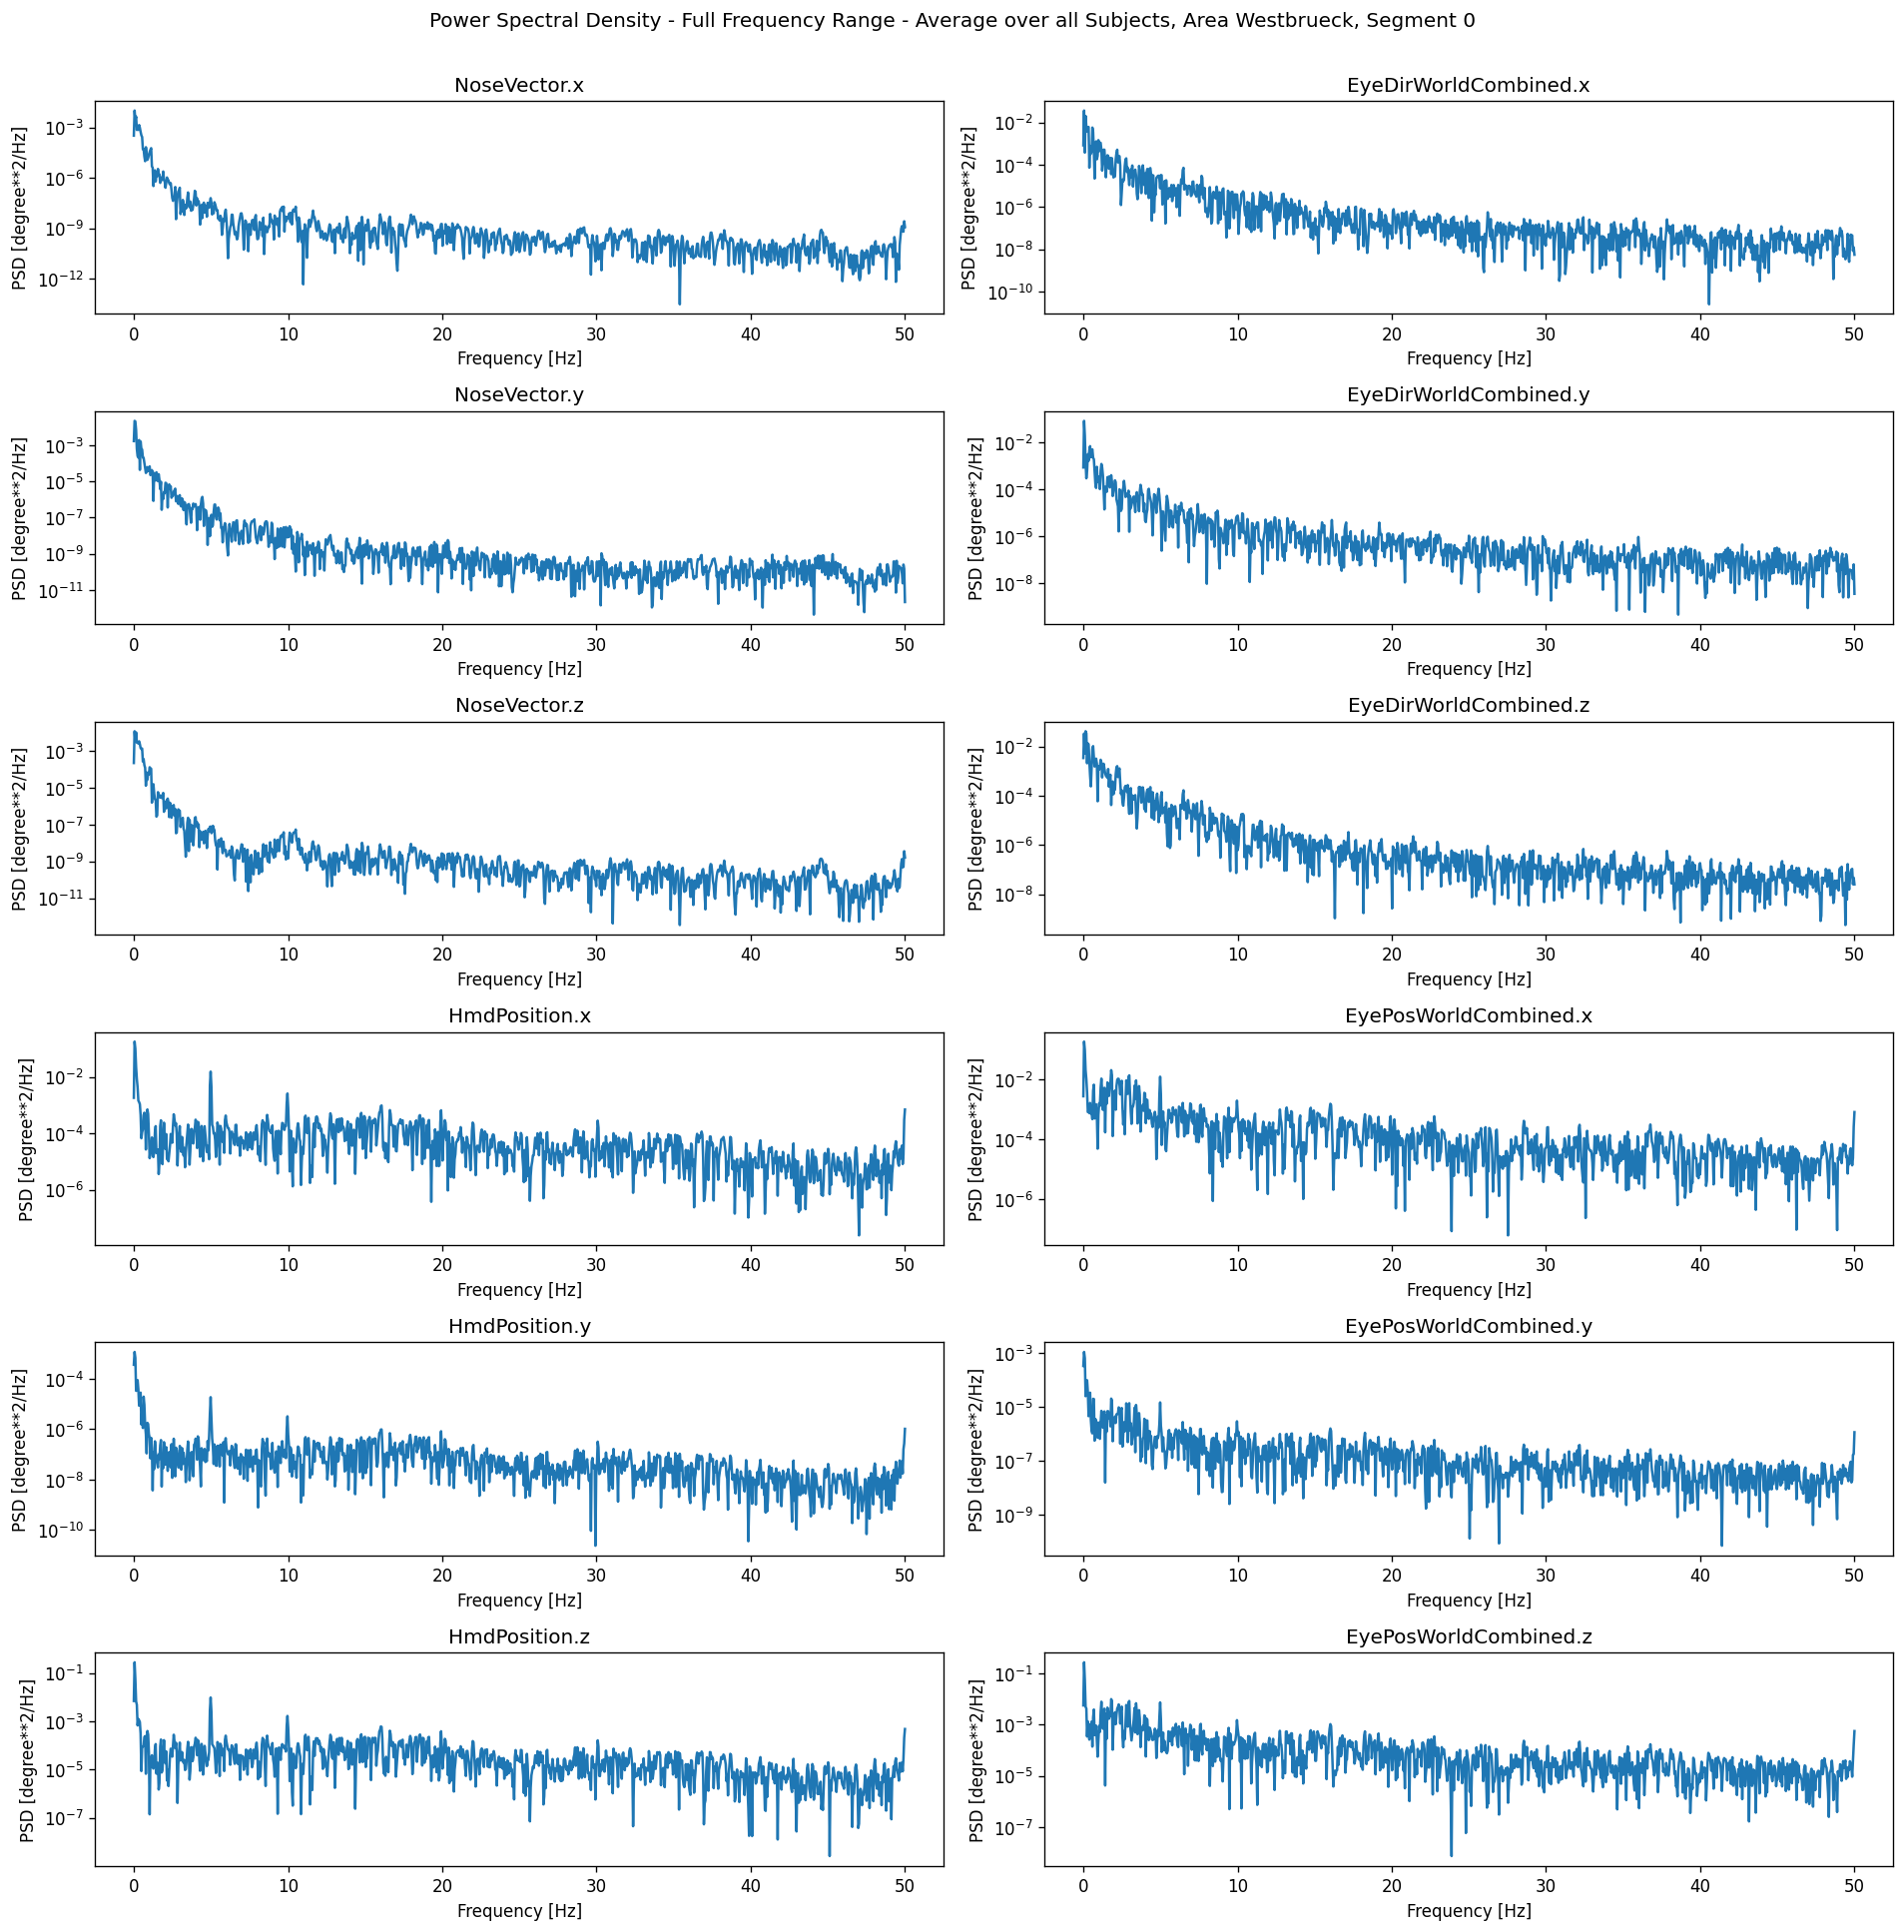

In [19]:
# Power Spectral Density - Full Frequency Range - Average over all Subjects

names_x = ["NoseVector.x","EyeDirWorldCombined.x","NoseVector.y","EyeDirWorldCombined.y","NoseVector.z","EyeDirWorldCombined.z", \
          "HmdPosition.x","EyePosWorldCombined.x","HmdPosition.y","EyePosWorldCombined.y","HmdPosition.z","EyePosWorldCombined.z"]
segment_data = average_over_all_participants_single_segment
plt_title = "Power Spectral Density - Full Frequency Range - Average over all Subjects, Area " + GLOBAL_AREA + ", Segment " + str(GLOBAL_SEGMENT)
fig_size = (16,16)
nrows = 6
ncols = 2
x_lim = -1
y_lim = -1
plot_power_spectral_densities(segment_data,names_x,plt_title,fig_size,nrows,ncols,x_lim,y_lim)



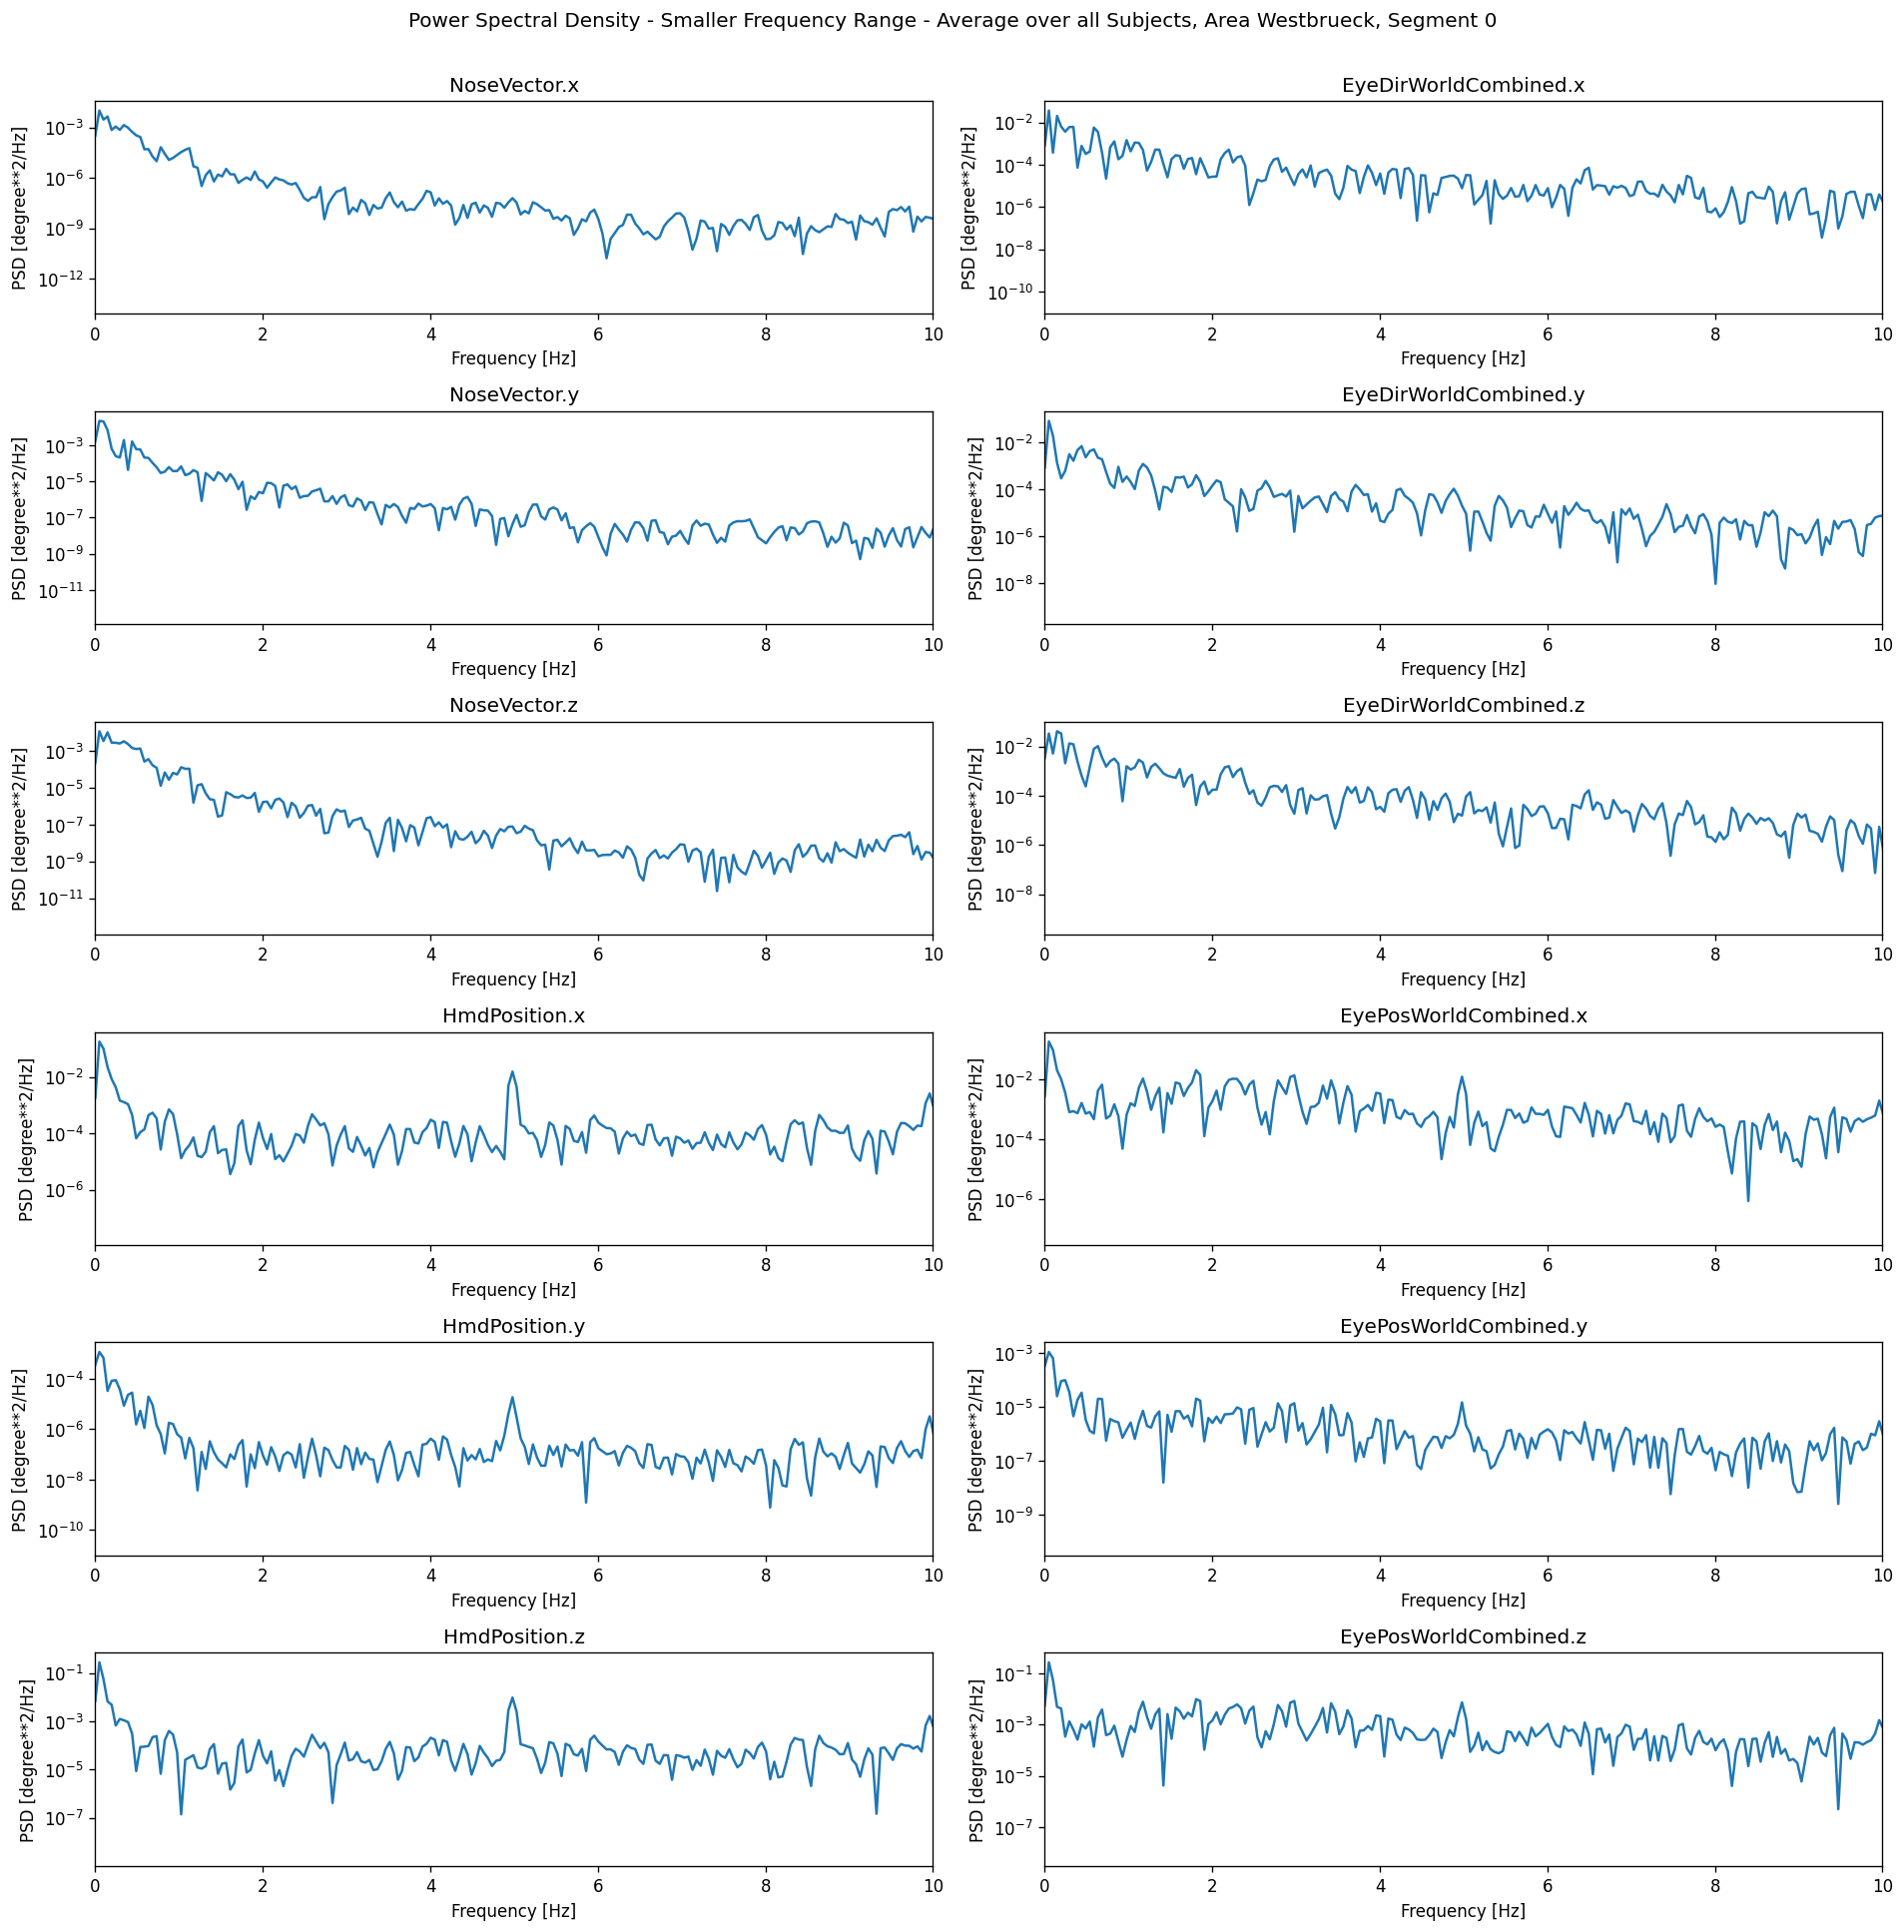

In [20]:
# Power Spectral Density - Smaller Frequency Range - Average over all Subjects

names_x = ["NoseVector.x","EyeDirWorldCombined.x","NoseVector.y","EyeDirWorldCombined.y","NoseVector.z","EyeDirWorldCombined.z", \
          "HmdPosition.x","EyePosWorldCombined.x","HmdPosition.y","EyePosWorldCombined.y","HmdPosition.z","EyePosWorldCombined.z"]
segment_data = average_over_all_participants_single_segment
plt_title = "Power Spectral Density - Smaller Frequency Range - Average over all Subjects, Area " + GLOBAL_AREA + ", Segment " + str(GLOBAL_SEGMENT)
fig_size = (16,16)
nrows = 6
ncols = 2
x_lim = 10
y_lim = -1
plot_power_spectral_densities(segment_data,names_x,plt_title,fig_size,nrows,ncols,x_lim,y_lim)



# Cross spectral density

In [21]:
def plot_cross_spectral_densities(segment_data,names_x,names_y,nperseg,plt_title,fig_size,nrows,ncols,x_lim=-1,y_lim=-1):
    
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=fig_size, dpi=120)

    for idx, row in enumerate(ax.reshape(-1)):
            x = segment_data[names_x[idx]]
            y = segment_data[names_y[idx]]

            sample_freqs, csd = signal.csd(x,y,fs=(1/0.01),nperseg=nperseg)
            row.semilogy(sample_freqs, np.abs(csd))
            row.set_xlabel("Frequency [Hz]")
            row.set_ylabel("CSD [degree**2/Hz]")
            if x_lim > 0:
                row.set_xlim(0,x_lim)
            if y_lim > 0:
                row.set_ylim(0,y_lim)
            row.set_title(names_x[idx] + " - " + names_y[idx])

    fig.suptitle(plt_title, y=1.005)
    fig.tight_layout()
    plt.show()
    

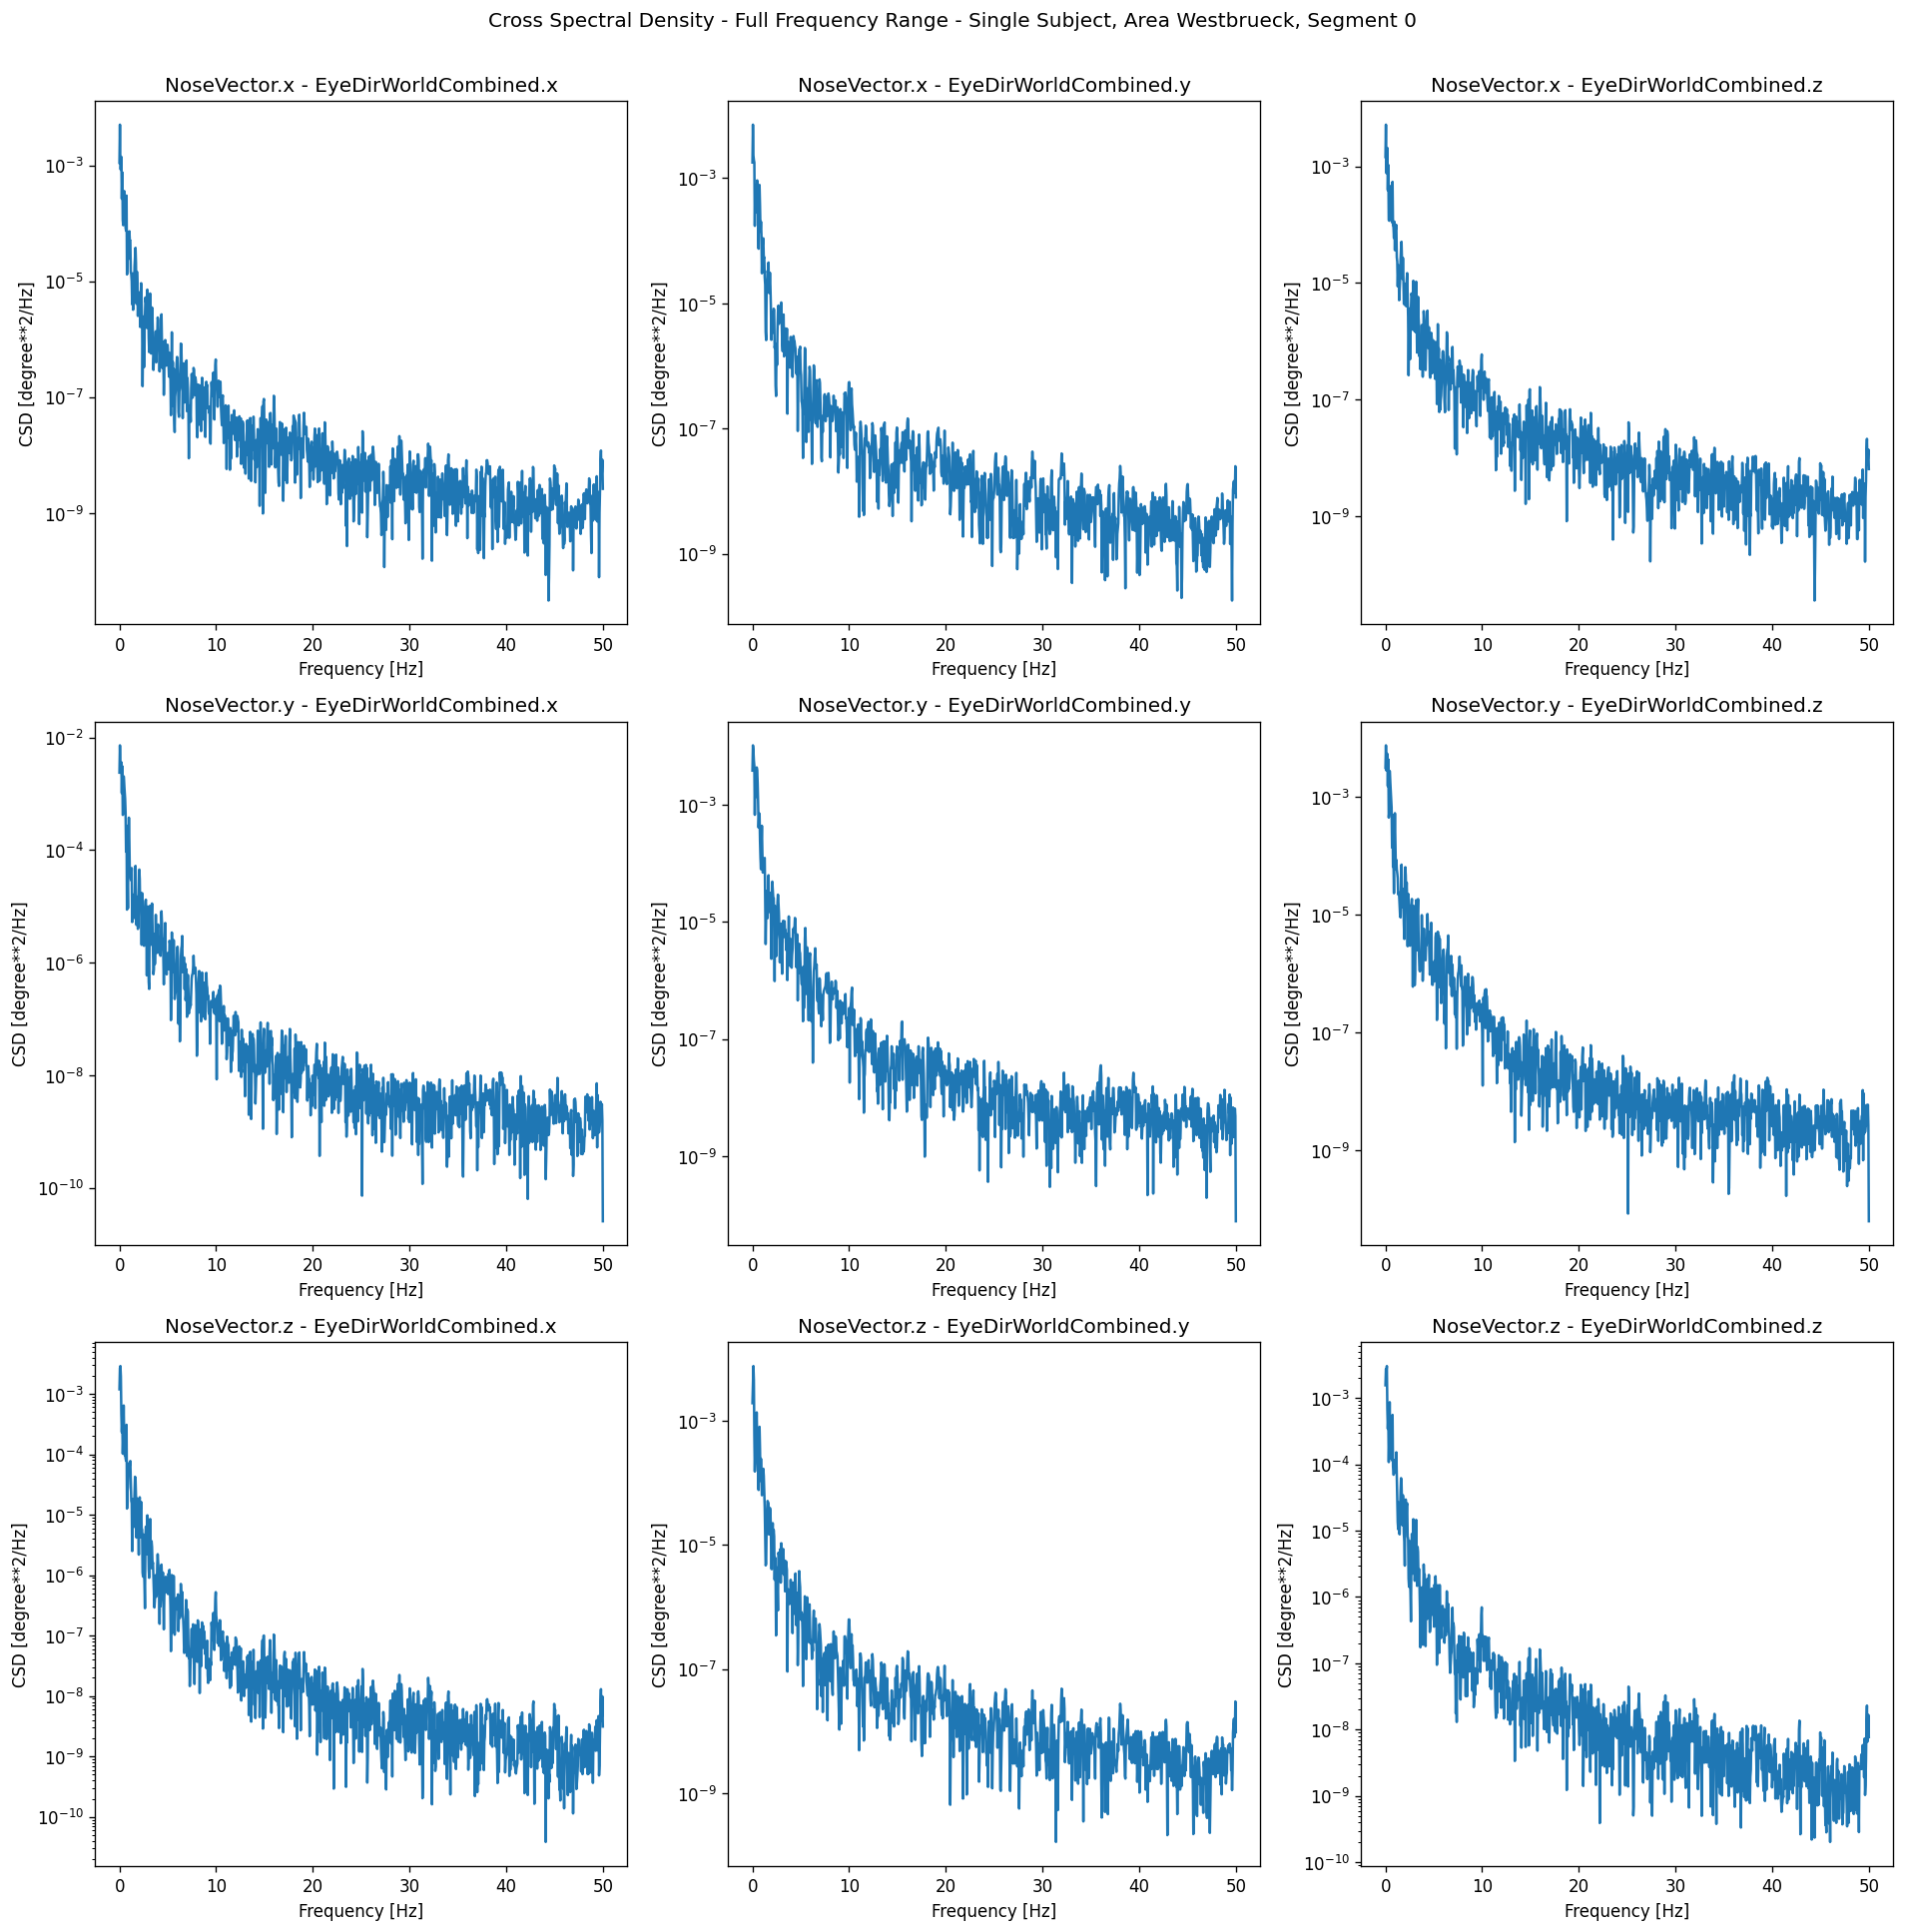

In [22]:
# Cross Spectral Density - Full Frequency Range - Single Subject     

segment_data = one_participant_single_segment
names_x = ["NoseVector.x","NoseVector.x","NoseVector.x","NoseVector.y","NoseVector.y","NoseVector.y","NoseVector.z","NoseVector.z","NoseVector.z"]
names_y = ["EyeDirWorldCombined.x","EyeDirWorldCombined.y","EyeDirWorldCombined.z","EyeDirWorldCombined.x","EyeDirWorldCombined.y","EyeDirWorldCombined.z","EyeDirWorldCombined.x","EyeDirWorldCombined.y","EyeDirWorldCombined.z"]
nperseg = 2048 
plt_title = "Cross Spectral Density - Full Frequency Range - Single Subject, Area " + GLOBAL_AREA + ", Segment " + str(GLOBAL_SEGMENT)
figsize=(12,6)
nrows = 3
ncols = 3
x_lim = -1
y_lim = -1 

plot_cross_spectral_densities(segment_data,names_x,names_y,nperseg,plt_title,fig_size,nrows,ncols,x_lim=-1,y_lim=-1)


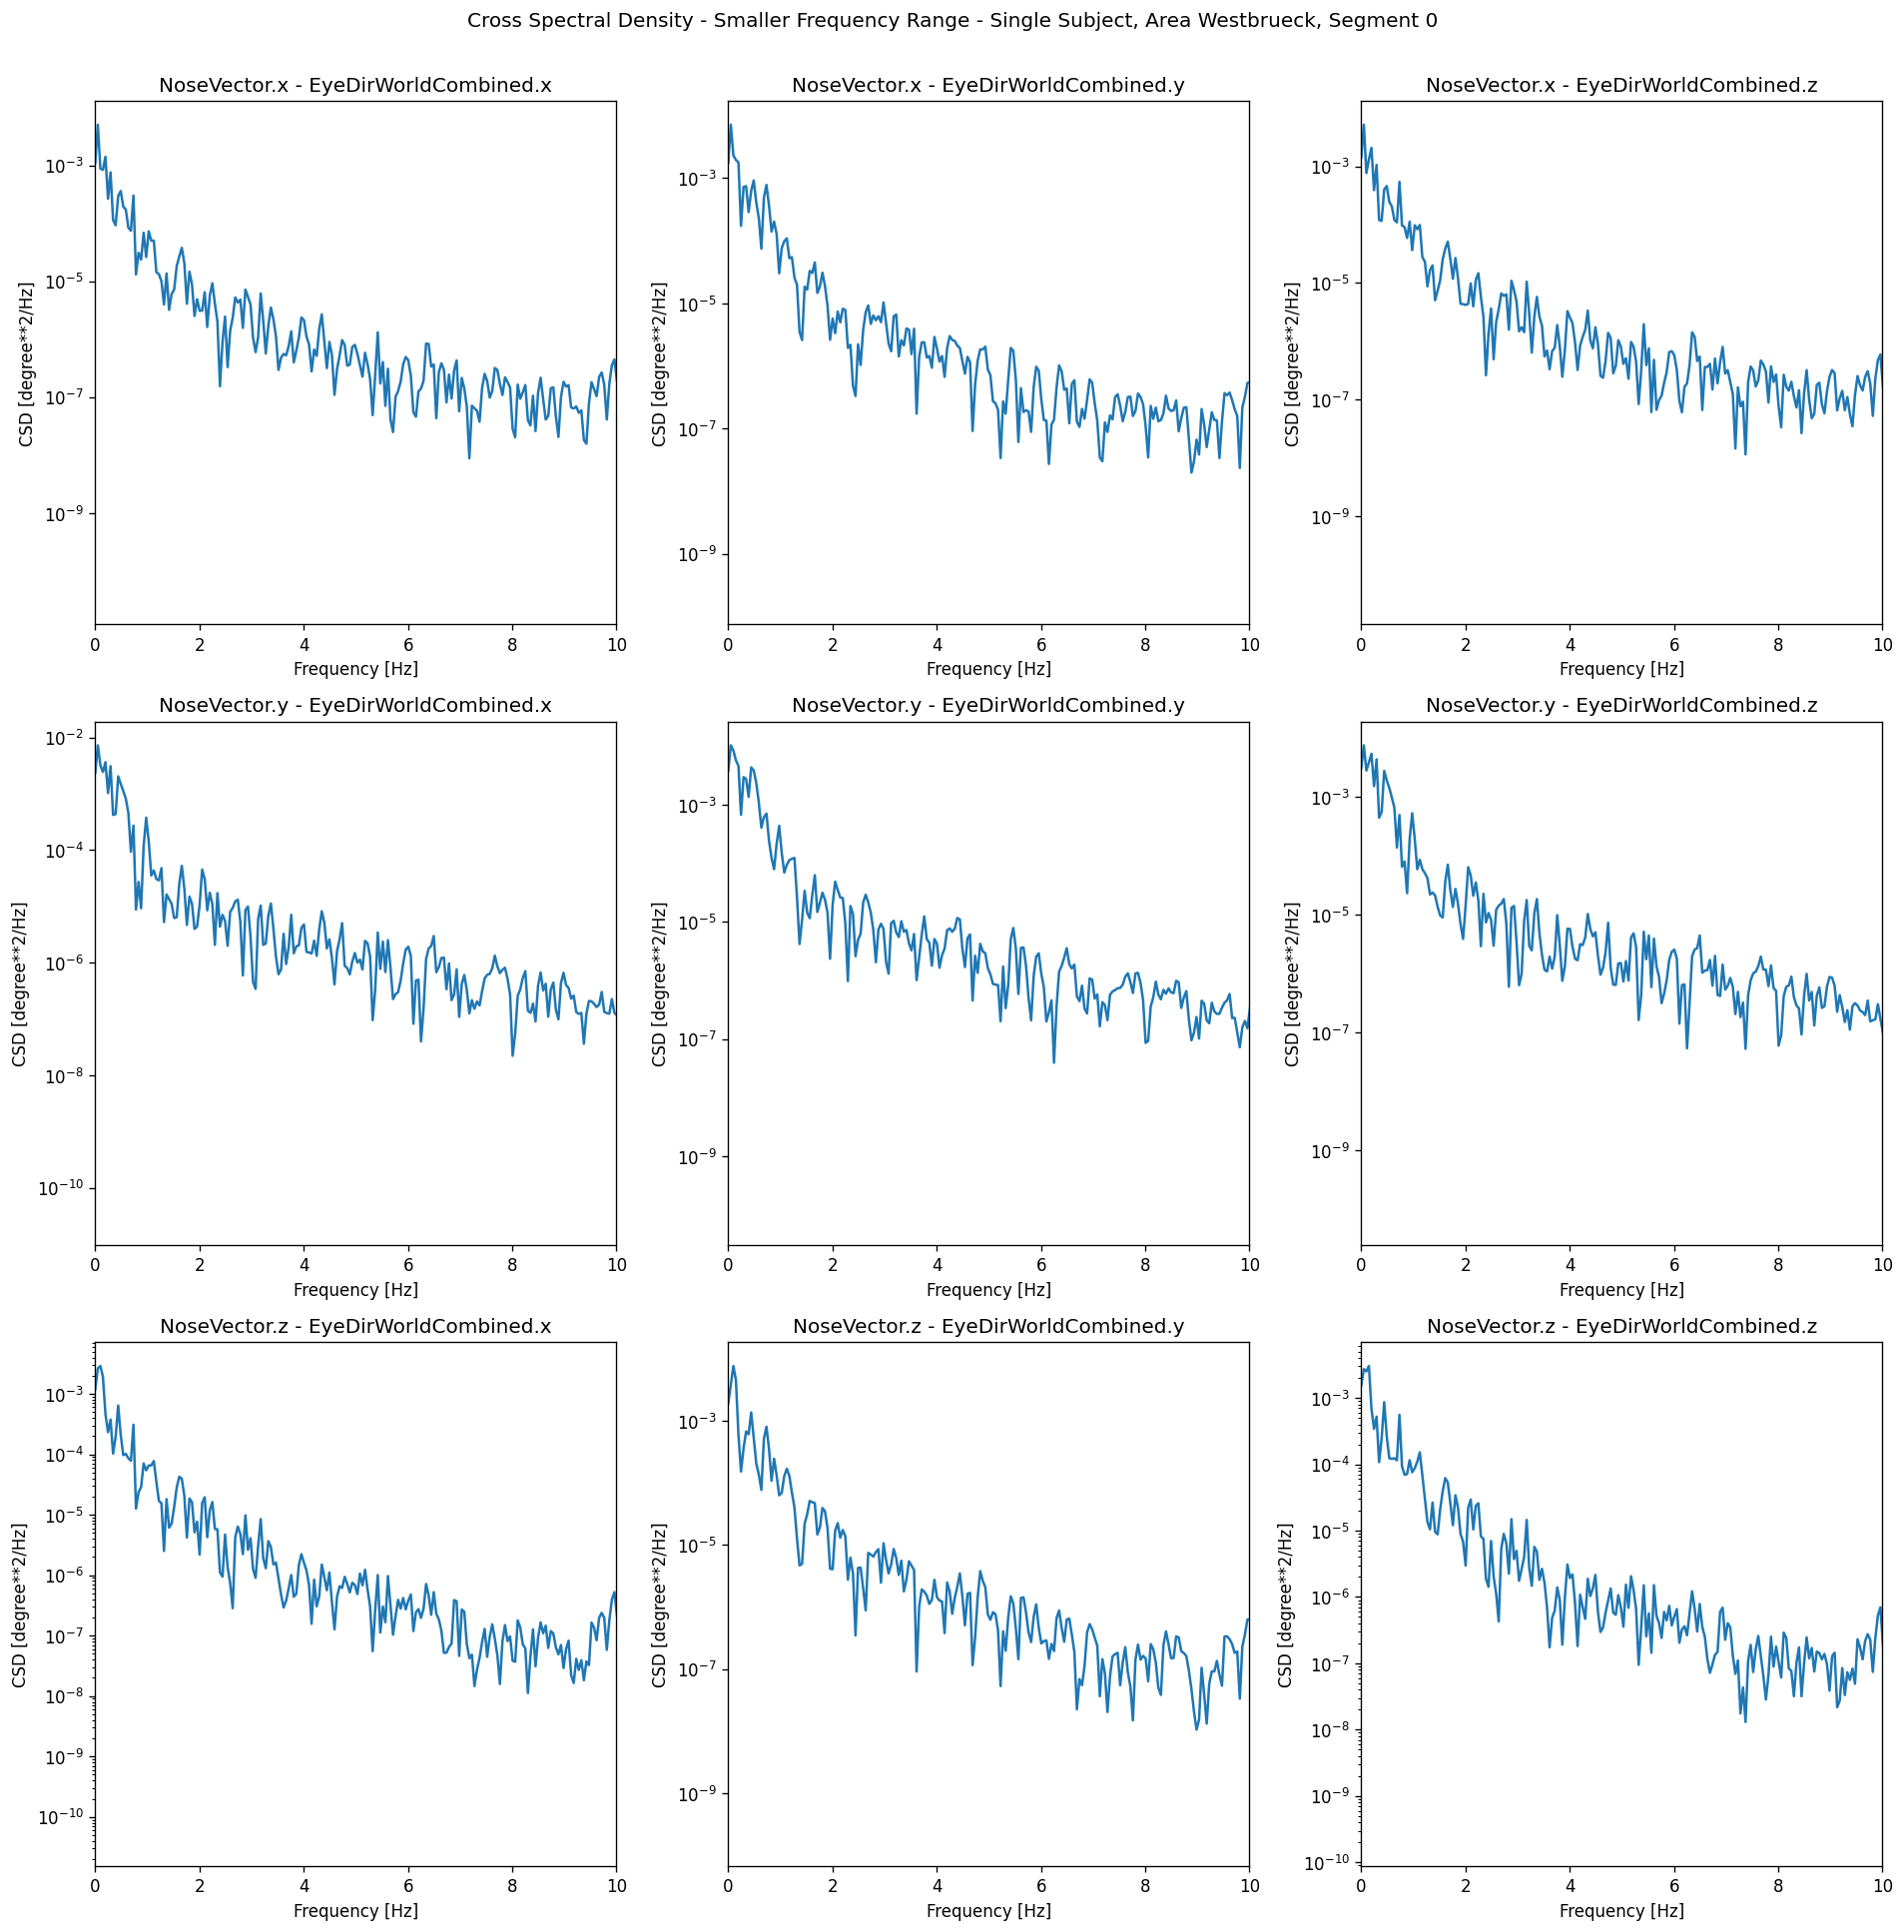

In [23]:
# Cross Spectral Density - Smaller Frequency Range - Single Subject

segment_data = one_participant_single_segment
names_x = ["NoseVector.x","NoseVector.x","NoseVector.x","NoseVector.y","NoseVector.y","NoseVector.y","NoseVector.z","NoseVector.z","NoseVector.z"]
names_y = ["EyeDirWorldCombined.x","EyeDirWorldCombined.y","EyeDirWorldCombined.z","EyeDirWorldCombined.x","EyeDirWorldCombined.y","EyeDirWorldCombined.z","EyeDirWorldCombined.x","EyeDirWorldCombined.y","EyeDirWorldCombined.z"]
nperseg = 2048 
plt_title = "Cross Spectral Density - Smaller Frequency Range - Single Subject, Area " + GLOBAL_AREA + ", Segment " + str(GLOBAL_SEGMENT)
figsize=(12,6)
nrows = 3
ncols = 3
x_lim = 10
y_lim = -1 

plot_cross_spectral_densities(segment_data,names_x,names_y,nperseg,plt_title,fig_size,nrows,ncols,x_lim,y_lim)



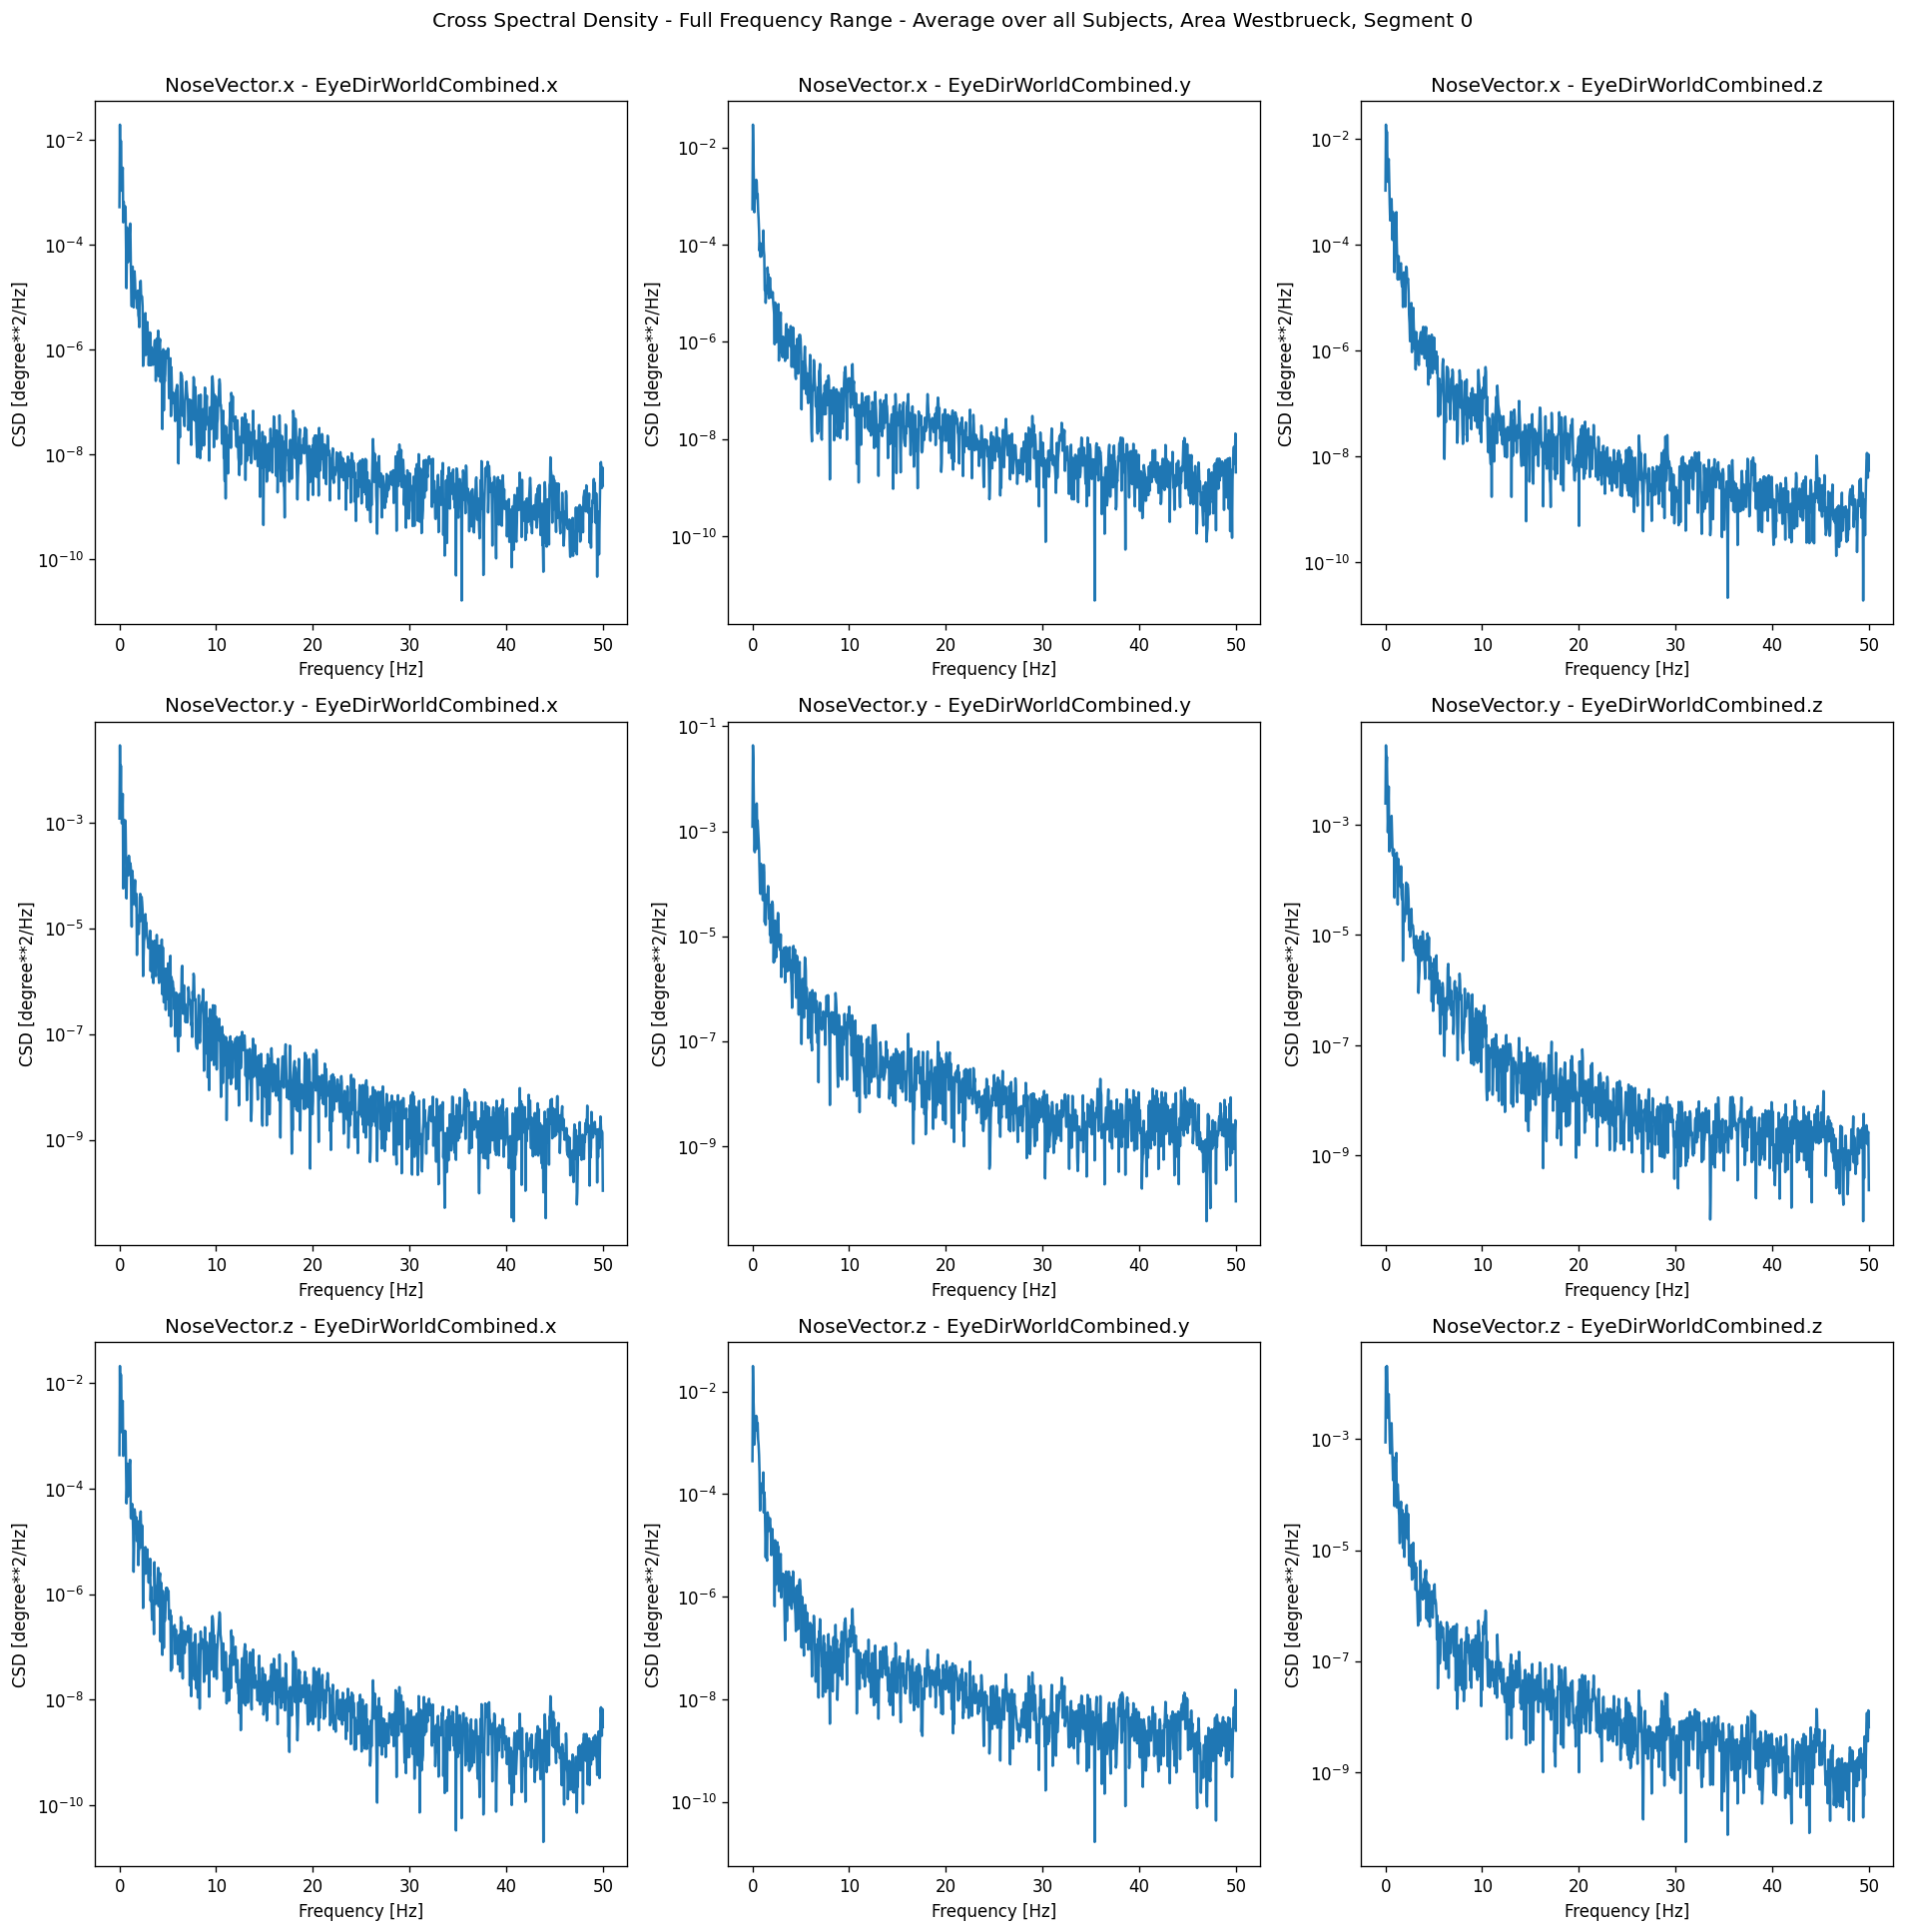

In [24]:
# Cross Spectral Density - Full Frequency Range - Average over all Subject

segment_data = average_over_all_participants_single_segment
names_x = ["NoseVector.x","NoseVector.x","NoseVector.x","NoseVector.y","NoseVector.y","NoseVector.y","NoseVector.z","NoseVector.z","NoseVector.z"]
names_y = ["EyeDirWorldCombined.x","EyeDirWorldCombined.y","EyeDirWorldCombined.z","EyeDirWorldCombined.x","EyeDirWorldCombined.y","EyeDirWorldCombined.z","EyeDirWorldCombined.x","EyeDirWorldCombined.y","EyeDirWorldCombined.z"]
nperseg = 2048 
plt_title = "Cross Spectral Density - Full Frequency Range - Average over all Subjects, Area " + GLOBAL_AREA + ", Segment " + str(GLOBAL_SEGMENT)
figsize=(12,6)
nrows = 3
ncols = 3
x_lim = -1
y_lim = -1 

plot_cross_spectral_densities(segment_data,names_x,names_y,nperseg,plt_title,fig_size,nrows,ncols,x_lim,y_lim)



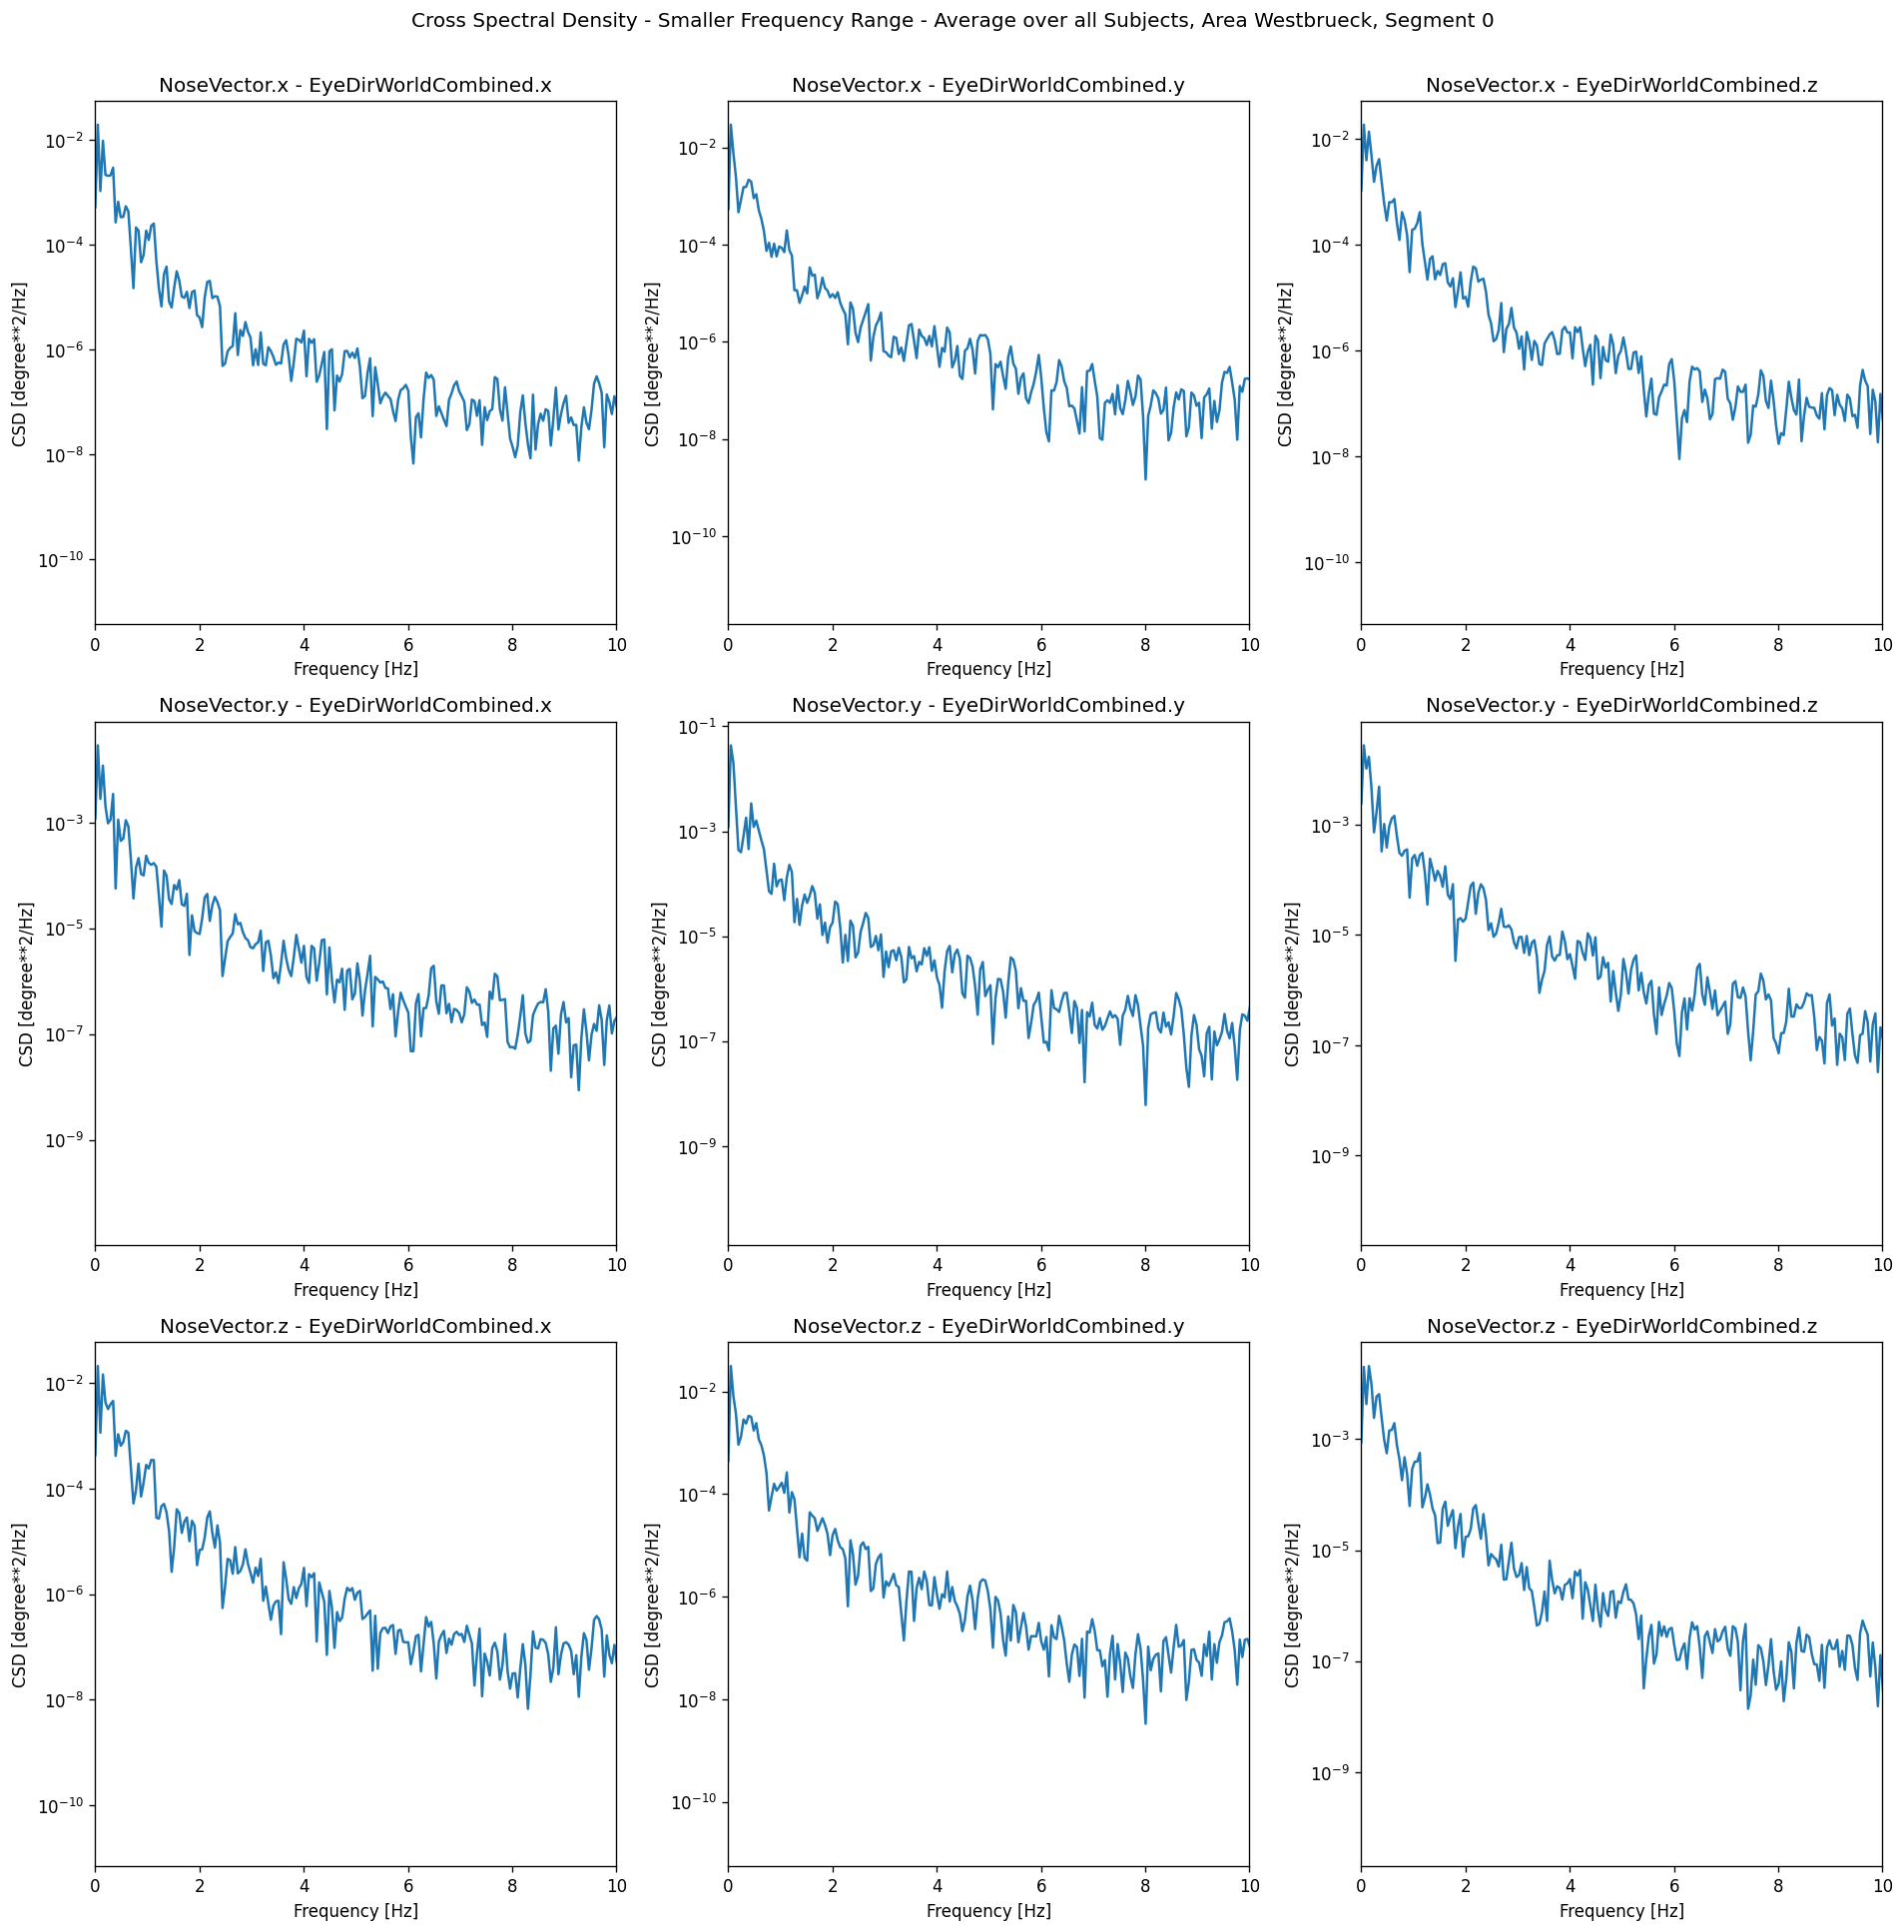

In [25]:
# Cross Spectral Density - Smaller Frequency Range - Average over all Subjects

segment_data = average_over_all_participants_single_segment
names_x = ["NoseVector.x","NoseVector.x","NoseVector.x","NoseVector.y","NoseVector.y","NoseVector.y","NoseVector.z","NoseVector.z","NoseVector.z"]
names_y = ["EyeDirWorldCombined.x","EyeDirWorldCombined.y","EyeDirWorldCombined.z","EyeDirWorldCombined.x","EyeDirWorldCombined.y","EyeDirWorldCombined.z","EyeDirWorldCombined.x","EyeDirWorldCombined.y","EyeDirWorldCombined.z"]
nperseg = 2048 
plt_title = "Cross Spectral Density - Smaller Frequency Range - Average over all Subjects, Area " + GLOBAL_AREA + ", Segment " + str(GLOBAL_SEGMENT)
figsize=(12,6)
nrows = 3
ncols = 3
x_lim = 10
y_lim = -1 

plot_cross_spectral_densities(segment_data,names_x,names_y,nperseg,plt_title,fig_size,nrows,ncols,x_lim,y_lim)




In [26]:
def plot_coherence(segment_data,names_x,names_y,nperseg,plt_title,fig_size,nrows,ncols,x_lim=-1,y_lim=-1):
    
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=fig_size, dpi=120)

    for idx, row in enumerate(ax.reshape(-1)):
            x = segment_data[names_x[idx]]
            y = segment_data[names_y[idx]]

            sample_freqs, csd = signal.coherence(x,y,fs=(1/0.01),nperseg=nperseg)
            row.semilogy(sample_freqs, csd)
            row.set_xlabel("Frequency [Hz]")
            row.set_ylabel("Coherence")
            if x_lim > 0:
                row.set_xlim(0,x_lim)
            if y_lim > 0:
                row.set_ylim(0,y_lim)
            row.set_title(names_x[idx] + " - " + names_y[idx])

    fig.suptitle(plt_title, y=1.005)
    fig.tight_layout()
    plt.show()
    

# Coherence

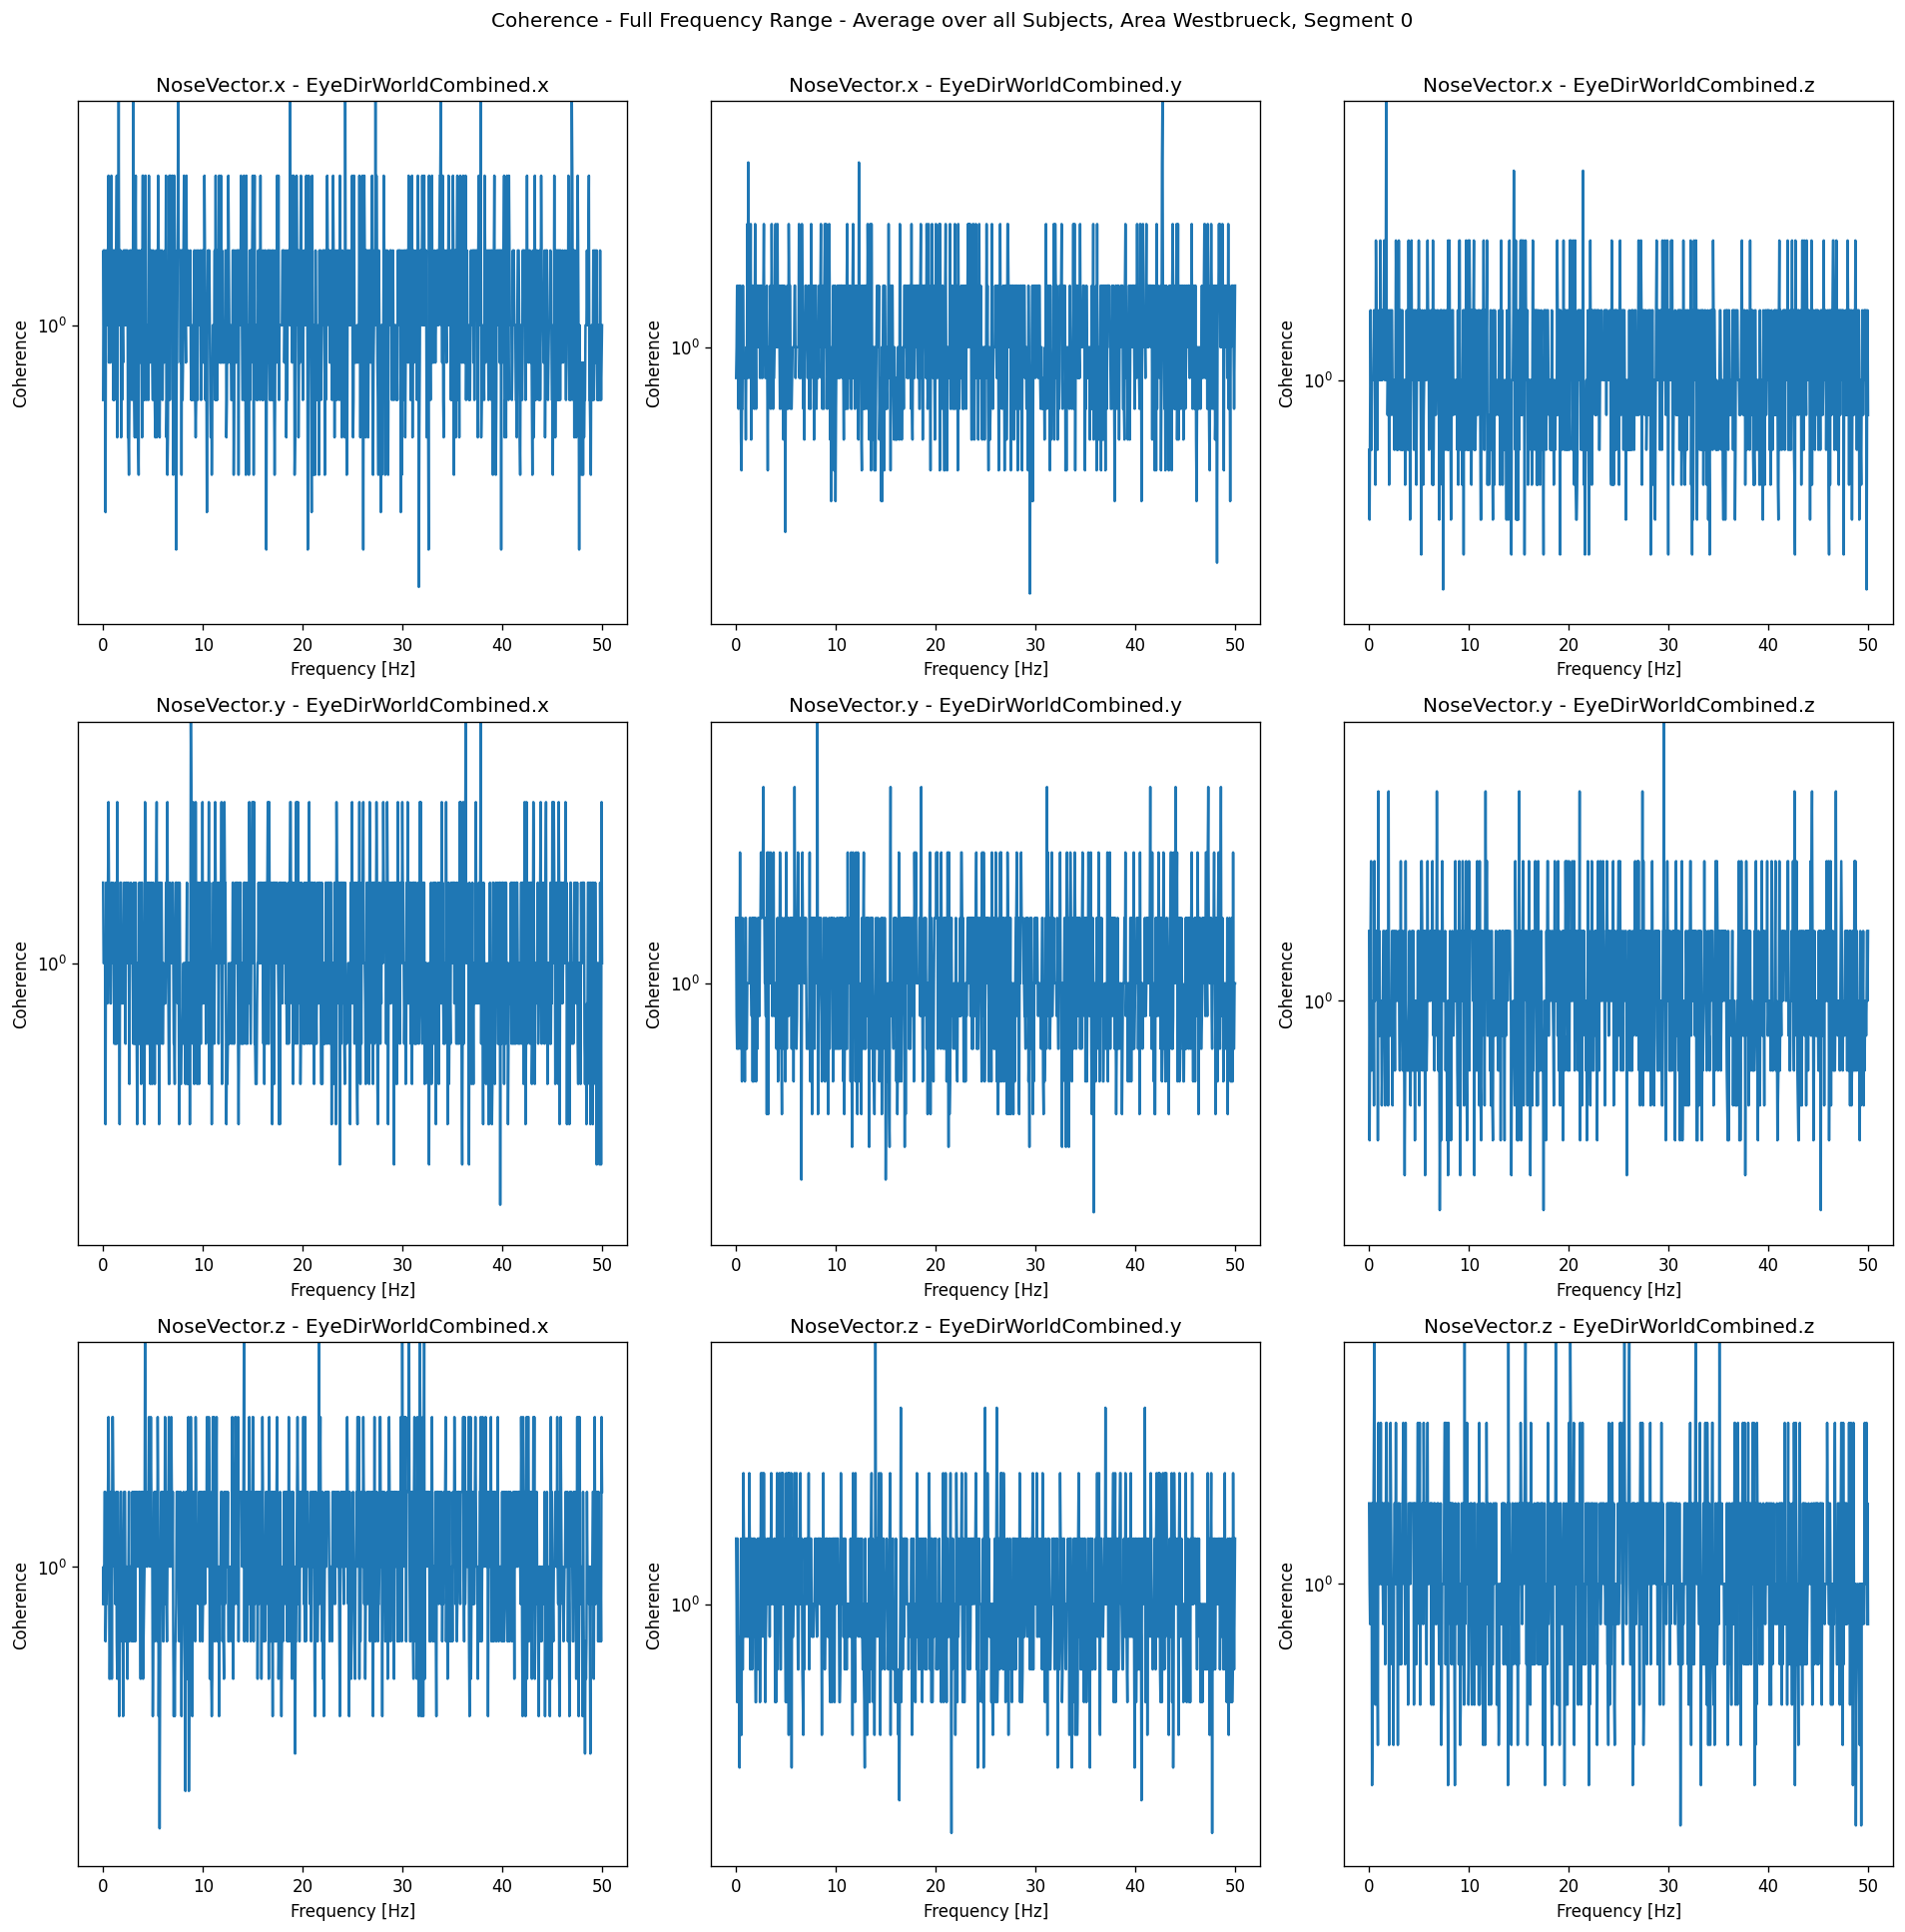

In [27]:
# Coherence - Full Frequency Range - Average over all Subjects

segment_data = average_over_all_participants_single_segment
names_x = ["NoseVector.x","NoseVector.x","NoseVector.x","NoseVector.y","NoseVector.y","NoseVector.y","NoseVector.z","NoseVector.z","NoseVector.z"]
names_y = ["EyeDirWorldCombined.x","EyeDirWorldCombined.y","EyeDirWorldCombined.z","EyeDirWorldCombined.x","EyeDirWorldCombined.y","EyeDirWorldCombined.z","EyeDirWorldCombined.x","EyeDirWorldCombined.y","EyeDirWorldCombined.z"]
nperseg = 2048 
plt_title = "Coherence - Full Frequency Range - Average over all Subjects, Area " + GLOBAL_AREA + ", Segment " + str(GLOBAL_SEGMENT)
figsize=(12,6)
nrows = 3
ncols = 3
x_lim = -1
y_lim = -1 

plot_coherence(segment_data,names_x,names_y,nperseg,plt_title,fig_size,nrows,ncols,x_lim,y_lim)


